# Exploratory Data Analysis: World Happiness Prediction (2015-2019)

### By Natalia López Gallego

-----------------------------------------------------------------------------



This notebook performs an exploratory data analysis (EDA) on world happiness datasets from 2015 to 2019. The data comes from the world happiness reports, which include variables such as GDP per capita, social support, life expectancy, freedom, generosity, and perception of corruption.

**Objectives**:
- Explore the distribution, correlations, and trends of the variables.
- Prepare the data to train a regression model that predicts the normalized `happiness_score` in the range [0, 10].

**Assumptions**:
- The datasets for different years have similar structures but inconsistent column names that will be standardized.
- Missing values will be handled through imputation or removal depending on their impact.

**Limitations**:
- Differences in columns between years may limit comparability.
- The amount of data per year is limited (~150-158 rows), which may affect the model's generalization.

#### Metadata
- **Author**: Natalia López Gallego
- **Python Version**: 3.12.10

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pycountry
from tabulate import tabulate
from pycountry_convert import country_name_to_country_alpha2, country_alpha2_to_continent_code
from rapidfuzz import process
import scipy.stats as stats
from scipy.stats import  skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


## 1. Data Loading and Cleaning

In this section, we load the datasets from 2015 to 2019, standardize the column names, convert them to `snake_case` format, and select only the common columns to facilitate analysis and modeling.

In [2]:
data = [
    "../data/external/2015.csv",
    "../data/external/2016.csv",
    "../data/external/2017.csv",
    "../data/external/2018.csv",
    "../data/external/2019.csv"
]

dfs = {}  # Dictionary to save DataFrames by year

for file in data:
    # Extract year from filename correctly
    year = file.split("/")[-1][:4]  # "2015.csv" → "2015"
    df = pd.read_csv(file)
    dfs[year] = df  # Save the DataFrame with key = year

In [3]:
for year, df in dfs.items():
    print(f"\n{year} DataFrame:\n")
    df.info()


2015 DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        158 non-null    object 
 1   Region                         158 non-null    object 
 2   Happiness Rank                 158 non-null    int64  
 3   Happiness Score                158 non-null    float64
 4   Standard Error                 158 non-null    float64
 5   Economy (GDP per Capita)       158 non-null    float64
 6   Family                         158 non-null    float64
 7   Health (Life Expectancy)       158 non-null    float64
 8   Freedom                        158 non-null    float64
 9   Trust (Government Corruption)  158 non-null    float64
 10  Generosity                     158 non-null    float64
 11  Dystopia Residual              158 non-null    float64
dtypes: float64(9), int64(1), object(

In [4]:
# Dictionary of standar names by year
column_renames = {
    "2015": {
        "Country": "Country",
        "Region": "Region",
        "Happiness Rank": "Happiness Rank",
        "Happiness Score": "Happiness Score",
        "Standard Error": "Standard Error",
        "Economy (GDP per Capita)": "Economy",
        "Family": "Family",
        "Health (Life Expectancy)": "Health",
        "Freedom": "Freedom",
        "Trust (Government Corruption)": "Trust",
        "Generosity": "Generosity",
        "Dystopia Residual": "Dystopia Residual"
    },
    "2016": {
        "Country": "Country",
        "Region": "Region",
        "Happiness Rank": "Happiness Rank",
        "Happiness Score": "Happiness Score",
        "Lower Confidence Interval": "CI Lower",
        "Upper Confidence Interval": "CI Upper",
        "Economy (GDP per Capita)": "Economy",
        "Family": "Family",
        "Health (Life Expectancy)": "Health",
        "Freedom": "Freedom",
        "Trust (Government Corruption)": "Trust",
        "Generosity": "Generosity",
        "Dystopia Residual": "Dystopia Residual"
    },
    "2017": {
        "Country": "Country",
        "Happiness.Rank": "Happiness Rank",
        "Happiness.Score": "Happiness Score",
        "Whisker.high": "CI Upper",
        "Whisker.low": "CI Lower",
        "Economy..GDP.per.Capita.": "Economy",
        "Family": "Family",
        "Health..Life.Expectancy.": "Health",
        "Freedom": "Freedom",
        "Trust..Government.Corruption.": "Trust",
        "Generosity": "Generosity",
        "Dystopia.Residual": "Dystopia Residual"
    },
    "2018": {
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy",
        "Social support": "Family",
        "Healthy life expectancy": "Health",
        "Freedom to make life choices": "Freedom",
        "Generosity": "Generosity",
        "Perceptions of corruption": "Trust"
    },
    "2019": {
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy",
        "Social support": "Family",
        "Healthy life expectancy": "Health",
        "Freedom to make life choices": "Freedom",
        "Generosity": "Generosity",
        "Perceptions of corruption": "Trust"
    }
}

# Apply renaming to each DataFrame in dfs
for year, df in dfs.items():
    if year in column_renames:
        dfs[year] = df.rename(columns=column_renames[year])


In [5]:
def to_snake_case(column_name):
    column_name = column_name.lower() 
    column_name = re.sub(r'\s+', '_', column_name) 
    column_name = re.sub(r'[^\w\s]', '', column_name)  
    return column_name

# Apply renaming to each DataFrame in dfs
for year, df in dfs.items():
    # Renaming each column to snake_case
    df.columns = [to_snake_case(col) for col in df.columns]

In [6]:
# Get the common columns across all DataFrames
common_columns = set(dfs['2015'].columns)  # Start with the columns from the first DataFrame (year 2015)

# Iterate through the DataFrames and update the common columns
for year, df in dfs.items():
    common_columns &= set(df.columns)  # Perform an intersection to keep only the common columns

# Convert the common columns to a list for later use
common_columns = list(common_columns)

# Filter the DataFrames so they only contain the common columns
for year, df in dfs.items():
    dfs[year] = df[common_columns]  # Filter each DataFrame to include only the shared columns

# Verify the result by printing the common columns of each DataFrame
for year, df in dfs.items():
    print(f"DataFrame for {year} with common columns:\n", df.columns)

DataFrame for 2015 with common columns:
 Index(['economy', 'freedom', 'trust', 'country', 'generosity',
       'happiness_rank', 'health', 'happiness_score', 'family'],
      dtype='object')
DataFrame for 2016 with common columns:
 Index(['economy', 'freedom', 'trust', 'country', 'generosity',
       'happiness_rank', 'health', 'happiness_score', 'family'],
      dtype='object')
DataFrame for 2017 with common columns:
 Index(['economy', 'freedom', 'trust', 'country', 'generosity',
       'happiness_rank', 'health', 'happiness_score', 'family'],
      dtype='object')
DataFrame for 2018 with common columns:
 Index(['economy', 'freedom', 'trust', 'country', 'generosity',
       'happiness_rank', 'health', 'happiness_score', 'family'],
      dtype='object')
DataFrame for 2019 with common columns:
 Index(['economy', 'freedom', 'trust', 'country', 'generosity',
       'happiness_rank', 'health', 'happiness_score', 'family'],
      dtype='object')


As seen in the previous output, the common columns across Dataframes are `generosity`, `economy`, `family`, `happiness_score`, `country`,`health`, `trust`, `happiness_rank`, and `freedom`.

The following process involves the standarization of country names using the `pycountry` library and fuzzy matching.

In [7]:
def standardize_country(country_name):
    """
    Standardizes country names using fuzzy matching with pycountry.

    Finds the closest match in pycountry based on fuzzy similarity and corrects discrepancies.

    Parameters:
    country_name (str): Name of the country from the dataset.

    Returns:
    str: The corrected country name or 'Unknown' if no match is found.
    """
    if pd.isna(country_name) or not isinstance(country_name, str):  # Handle missing/null values
        return "Unknown"

    country_name = country_name.strip()  # Remove extra spaces
    country_list = [country.name for country in pycountry.countries]  # Get official country names

    match_result = process.extractOne(country_name, country_list)  # Fuzzy match

    if match_result:  
        best_match, score = match_result[:2]  # Extract only first two values
        return best_match if score > 80 else "Unknown"
    
    return "Unknown"  # Default fallback if no match found

In [8]:
for year, df in dfs.items():
    if "country" in df.columns:
        df["Standardized Country"] = df["country"].apply(standardize_country)  # Standardize names


Now, we are going to create a new column that stores the continent for a given standardized country name.

In [9]:
def get_continent(country_name):
    """
    Returns the continent for a given standardized country name.

    Uses pycountry-convert to map country names to ISO Alpha-2 codes, then to continent codes.

    Parameters:
    country_name (str): Standardized country name.

    Returns:
    str: The continent the country belongs to, or 'Unknown' if not found.
    """
    if pd.isna(country_name) or not isinstance(country_name, str):  # Handle missing/null values
        return "Unknown"

    country_name = country_name.strip()  # Remove extra spaces

    try:
        # Convert country name to Alpha-2 code
        country_code = country_name_to_country_alpha2(country_name)

        # Convert Alpha-2 code to continent
        continent_code = country_alpha2_to_continent_code(country_code)

        # Continent mapping dictionary
        continent_mapping = {
            "NA": "North America",
            "SA": "South America",
            "EU": "Europe",
            "AF": "Africa",
            "AS": "Asia",
            "OC": "Oceania"
        }

        return continent_mapping.get(continent_code, "Unknown")

    except (KeyError, LookupError):
        return "Unknown"  # Handle cases where mapping fails

In [10]:
for year, df in dfs.items():
    if "Standardized Country" in df.columns:
        df["Continent"] = df["Standardized Country"].apply(get_continent)

In [11]:
# Collect unique continent values from all DataFrames
unique_continents = set()

for year, df in dfs.items():
    if "Continent" in df.columns:
        unique_continents.update(df["Continent"].unique())  # Add unique values

# Print sorted list of unique continents
print(sorted(unique_continents))

['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America', 'Unknown']


The name of the column is changed to snake case.

In [12]:
for year, df in dfs.items():
    if "Continent" in df.columns:
        df.rename(columns={"Continent": "continent"}, inplace=True)

And finally we verify the available columns in each DataFrame.

In [13]:
for year, df in dfs.items():
    print(f"Columns in {year}:")
    print(df.columns.tolist())  # Converts column index to list for easy reading
    print("-" * 40)  # Adds a separator for better readability

Columns in 2015:
['economy', 'freedom', 'trust', 'country', 'generosity', 'happiness_rank', 'health', 'happiness_score', 'family', 'Standardized Country', 'continent']
----------------------------------------
Columns in 2016:
['economy', 'freedom', 'trust', 'country', 'generosity', 'happiness_rank', 'health', 'happiness_score', 'family', 'Standardized Country', 'continent']
----------------------------------------
Columns in 2017:
['economy', 'freedom', 'trust', 'country', 'generosity', 'happiness_rank', 'health', 'happiness_score', 'family', 'Standardized Country', 'continent']
----------------------------------------
Columns in 2018:
['economy', 'freedom', 'trust', 'country', 'generosity', 'happiness_rank', 'health', 'happiness_score', 'family', 'Standardized Country', 'continent']
----------------------------------------
Columns in 2019:
['economy', 'freedom', 'trust', 'country', 'generosity', 'happiness_rank', 'health', 'happiness_score', 'family', 'Standardized Country', 'continen

The original `country` column is dropped.

In [14]:
for year, df in dfs.items():
    columns_to_drop = ["country"]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

Now the `Standardized Country` column is renamed to `country`.

In [15]:
for year, df in dfs.items():
    if "Standardized Country" in df.columns:
        df.rename(columns={"Standardized Country": "country"}, inplace=True)

Once again we verify the resulting columns.

In [16]:
for year, df in dfs.items():
    print(f"Columns in {year}:")
    print(df.columns.tolist())  # Converts column index to list for easy reading
    print("-" * 40)  # Adds a separator for better readability

Columns in 2015:
['economy', 'freedom', 'trust', 'generosity', 'happiness_rank', 'health', 'happiness_score', 'family', 'country', 'continent']
----------------------------------------
Columns in 2016:
['economy', 'freedom', 'trust', 'generosity', 'happiness_rank', 'health', 'happiness_score', 'family', 'country', 'continent']
----------------------------------------
Columns in 2017:
['economy', 'freedom', 'trust', 'generosity', 'happiness_rank', 'health', 'happiness_score', 'family', 'country', 'continent']
----------------------------------------
Columns in 2018:
['economy', 'freedom', 'trust', 'generosity', 'happiness_rank', 'health', 'happiness_score', 'family', 'country', 'continent']
----------------------------------------
Columns in 2019:
['economy', 'freedom', 'trust', 'generosity', 'happiness_rank', 'health', 'happiness_score', 'family', 'country', 'continent']
----------------------------------------


## 2. Exploratory Data Analysis

We explore the structure of the data, check for missing values, analyze distributions, correlations, outliers, and temporal trends to better understand the variables and their relationship with `happiness_score`.

First we check the dimensions of each DataFrame, and we observe each one of them have almost the same number of rows.


In [17]:
for year, df in dfs.items():
    print(f"DataFrame for {year} - Number of rows and columns:\n", df.shape)

DataFrame for 2015 - Number of rows and columns:
 (158, 10)
DataFrame for 2016 - Number of rows and columns:
 (157, 10)
DataFrame for 2017 - Number of rows and columns:
 (155, 10)
DataFrame for 2018 - Number of rows and columns:
 (156, 10)
DataFrame for 2019 - Number of rows and columns:
 (156, 10)


### **Descriptive statistics**

Each element of the dictionary `dfs` is traversed, where year represents the year (dictionary key) and `df` is the DataFrame corresponding to that year.Then the  `df.describe()` function generates a statistical summary of the DataFrame, including metrics such as:

In [18]:
for year, df in dfs.items():
    print(f"Describe for {year}:\n", df.describe(), "\n")

Describe for 2015:
           economy     freedom       trust  generosity  happiness_rank  \
count  158.000000  158.000000  158.000000  158.000000      158.000000   
mean     0.846137    0.428615    0.143422    0.237296       79.493671   
std      0.403121    0.150693    0.120034    0.126685       45.754363   
min      0.000000    0.000000    0.000000    0.000000        1.000000   
25%      0.545808    0.328330    0.061675    0.150553       40.250000   
50%      0.910245    0.435515    0.107220    0.216130       79.500000   
75%      1.158448    0.549092    0.180255    0.309883      118.750000   
max      1.690420    0.669730    0.551910    0.795880      158.000000   

           health  happiness_score      family  
count  158.000000       158.000000  158.000000  
mean     0.630259         5.375734    0.991046  
std      0.247078         1.145010    0.272369  
min      0.000000         2.839000    0.000000  
25%      0.439185         4.526000    0.856823  
50%      0.696705         5.

#### **Key Observations:**
1. **Happiness Score Stability:**  
   - The mean happiness score hovers around **5.35 - 5.40** across years, indicating general stability in global happiness levels.
   - The minimum values are consistently below **3**, suggesting there are countries with very low happiness levels.
   - The maximum score varies but remains within **7.5 - 7.7**, pointing to highly satisfied populations at the top.

2. **Economic Influence:**  
   - The economy metric shows an upward trend, with a mean value increasing from **0.84 in 2015** to **0.98 in 2017**, peaking at **0.90 in 2019**.
   - This suggests economic improvements globally, though variability persists (high standard deviations).

3. **Family & Social Support:**  
   - The family metric fluctuates but increases slightly, reaching **1.2 in 2018 and 2019**, reflecting a growing emphasis on social relationships.
   - The max values show some nations with high social cohesion and support.

4. **Health & Life Expectancy:**  
   - There is a notable **increase in the mean health score**, rising from **0.63 in 2015** to **0.72 in 2019**.
   - This suggests global improvements in healthcare, but certain regions still report **near-zero values**, indicating disparities.

5. **Freedom & Trust:**  
   - **Freedom levels show minor fluctuation**, peaking at **0.45 in 2018**, but dropping slightly in 2019.
   - **Trust declines steadily**, from **0.14 in 2015 to 0.11 in 2019**, possibly indicating growing concerns about corruption and governance.

6. **Generosity Declining:**  
   - Generosity starts at **0.23 in 2015** but drops to **0.18 in 2018 and 2019**.
   - This trend may reflect shifting priorities or economic challenges affecting charitable giving.

7. **Happiness Rank Distribution:**  
   - The **ranking dispersion is relatively wide** (std ≈ 45), meaning significant differences in happiness levels across countries.
   - **The highest rank is always 1, while the lowest corresponds to the number of countries studied.**

#### **Final Insights:**
- There are **positive trends** in economy, family, and health, suggesting overall global improvements.
- However, **trust and generosity** decline, which may indicate rising concerns about governance or social cohesion.
- Happiness levels remain **relatively stable**, meaning external changes haven't dramatically shifted emotional well-being.

### **Detecting ouliers**

In [19]:
def detect_outliers(df):
    """
    Detects outliers in numerical columns of a DataFrame using the Interquartile Range (IQR) method.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing numerical data.

    Returns:
    dict: A dictionary where keys are column names and values are lists of indices containing outliers.
    
    Outliers are identified as values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
    """
    outliers = {}
    for column in df.select_dtypes(include=[np.number]).columns:  # Select only numerical columns
        # Compute quartiles
        Q1 = df[column].quantile(0.25)  # First quartile (25%)
        Q3 = df[column].quantile(0.75)  # Third quartile (75%)
        IQR = Q3 - Q1  # Interquartile range

        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers and store their indices
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index.tolist()

    return outliers

# Iterate over the DataFrames to detect outliers
for year, df in dfs.items():
    outliers = detect_outliers(df)  # Call the function for each year's DataFrame
    print(f"Detected Outliers for {year}:\n", outliers, "\n")  # Print detected outliers

Detected Outliers for 2015:
 {'economy': [], 'freedom': [], 'trust': [0, 2, 3, 5, 7, 8, 16, 19, 23, 27, 71, 90, 129, 153], 'generosity': [33, 128], 'happiness_rank': [], 'health': [], 'happiness_score': [], 'family': [147, 152, 157]} 

Detected Outliers for 2016:
 {'economy': [], 'freedom': [], 'trust': [0, 1, 3, 4, 7, 9, 19, 21, 27, 35, 96, 151], 'generosity': [29, 32, 78, 118], 'happiness_rank': [], 'health': [], 'happiness_score': [], 'family': [154]} 

Detected Outliers for 2017:
 {'economy': [], 'freedom': [], 'trust': [0, 1, 3, 4, 7, 8, 9, 14, 17, 20, 25, 34, 150], 'generosity': [80, 113], 'happiness_rank': [], 'health': [], 'happiness_score': [], 'family': [142, 149, 151, 154]} 

Detected Outliers for 2018:
 {'economy': [19], 'freedom': [136, 141], 'trust': [0, 1, 2, 4, 5, 6, 7, 8, 9, 13, 14, 16, 18, 33, 75, 97, 150], 'generosity': [95, 129], 'happiness_rank': [], 'health': [], 'happiness_score': [], 'family': [135, 149, 154]} 

Detected Outliers for 2019:
 {'economy': [], 'free

#### **Analysis of Detected Outliers (2015–2019)**

#### **Key Observations Across Years**
1. **Generosity Outliers**  
   - Appears consistently across all years with different indices.  
   - Outliers could indicate extreme generosity levels in certain countries, either exceptionally high or very low.  
   - The number of outliers fluctuates (e.g., **2 in 2015**, **4 in 2016**, **2 in 2017**), possibly reflecting variations in charitable contributions or measurement methods.

2. **Family Support Outliers**  
   - Certain countries have extreme deviations in family support (e.g., **147, 152, 157 in 2015**, **154 in 2016**, etc.).  
   - This suggests significant differences in social structures or reported relationships.  
   - More outliers appear in **2017 and 2019**, meaning family support may have varied more significantly over time.

3. **Trust Outliers (Government & Society)**  
   - Trust consistently has the highest number of outliers across all years.  
   - Countries showing extreme values (either very high or very low) highlight significant disparities in societal confidence and corruption perception.  
   - The number of outliers seems to **increase in later years (2018, 2019)**, possibly indicating growing political instability or distrust in governance.

4. **Freedom Outliers**  
   - This factor only has outliers in **2018 (136, 141) and 2019 (153)**.  
   - This could suggest increasing polarization in perceived freedoms, with certain nations showing unusually low or high values.

5. **Economy & Happiness Score**  
   - **Economy has almost no outliers**, except one instance in **2018 (index 19)**.  
   - **Happiness Score has no outliers at all**, indicating relative consistency across nations.

6. **Health Outliers (2019 Only)**  
   - The only outlier appears in **2019 (index 134)**, suggesting one country reported an exceptionally high or low health score that year.

#### **Final Insights**
- **Trust & Generosity** seem to be the most variable factors, with extreme highs and lows across different countries.  
- **Family Support fluctuates** more over time, with more outliers appearing in later years.  
- **Freedom shows irregular extreme values** only in the last two years, possibly due to policy or societal changes.  
- **Happiness scores remain relatively stable**, which aligns with global trends of slow-moving happiness shifts.  
- **Health & Economy show minimal outliers**, meaning these factors tend to be more stable globally.

### **Detecting null values**

In [20]:
# Iterate over the DataFrames and detect null values
for year, df in dfs.items():
    print(f"Null values for {year}:\n")  # Print a heading for the current DataFrame

    # Display the count of null values per column
    null_counts = df.isnull().sum()  # Calculate the number of null values for each column

    # Print only the columns that have null values
    print(null_counts[null_counts > 0], "\n")  # Filter and print columns where null values exist

Null values for 2015:

Series([], dtype: int64) 

Null values for 2016:

Series([], dtype: int64) 

Null values for 2017:

Series([], dtype: int64) 

Null values for 2018:

trust    1
dtype: int64 

Null values for 2019:

Series([], dtype: int64) 



Only one null value is present in the `trust` column for 2018.

## Exploring Distributions

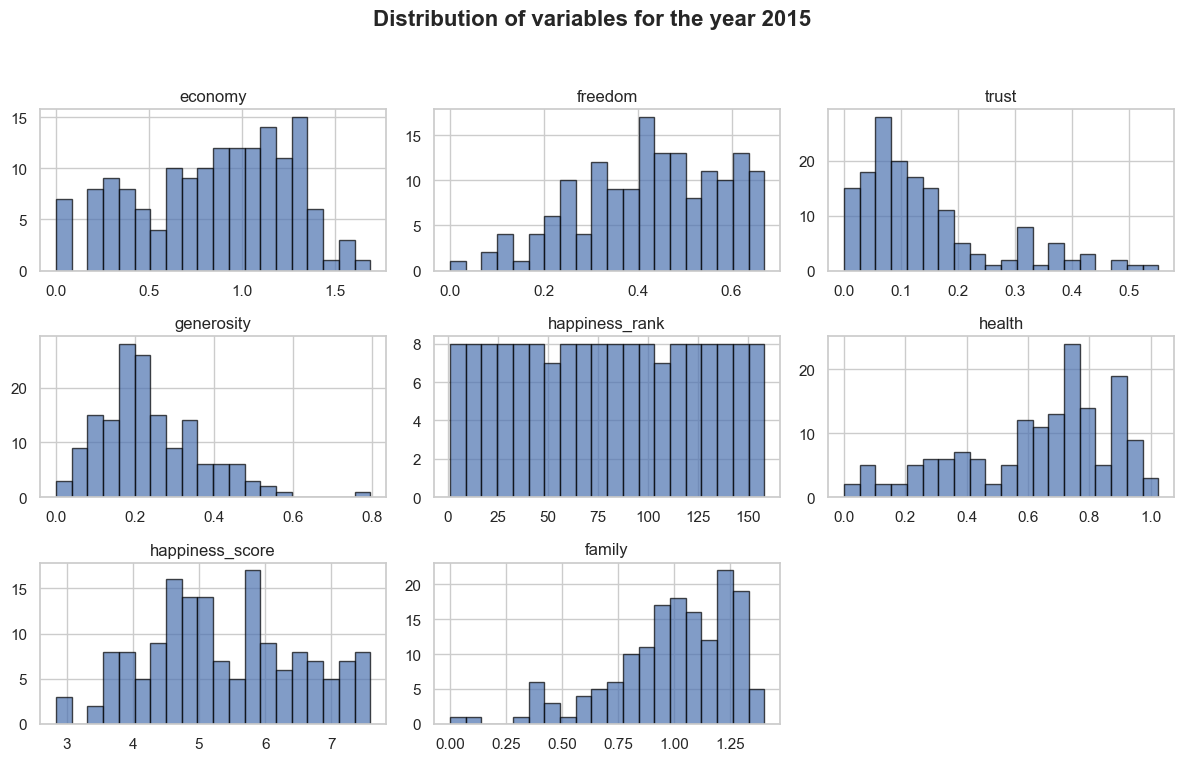

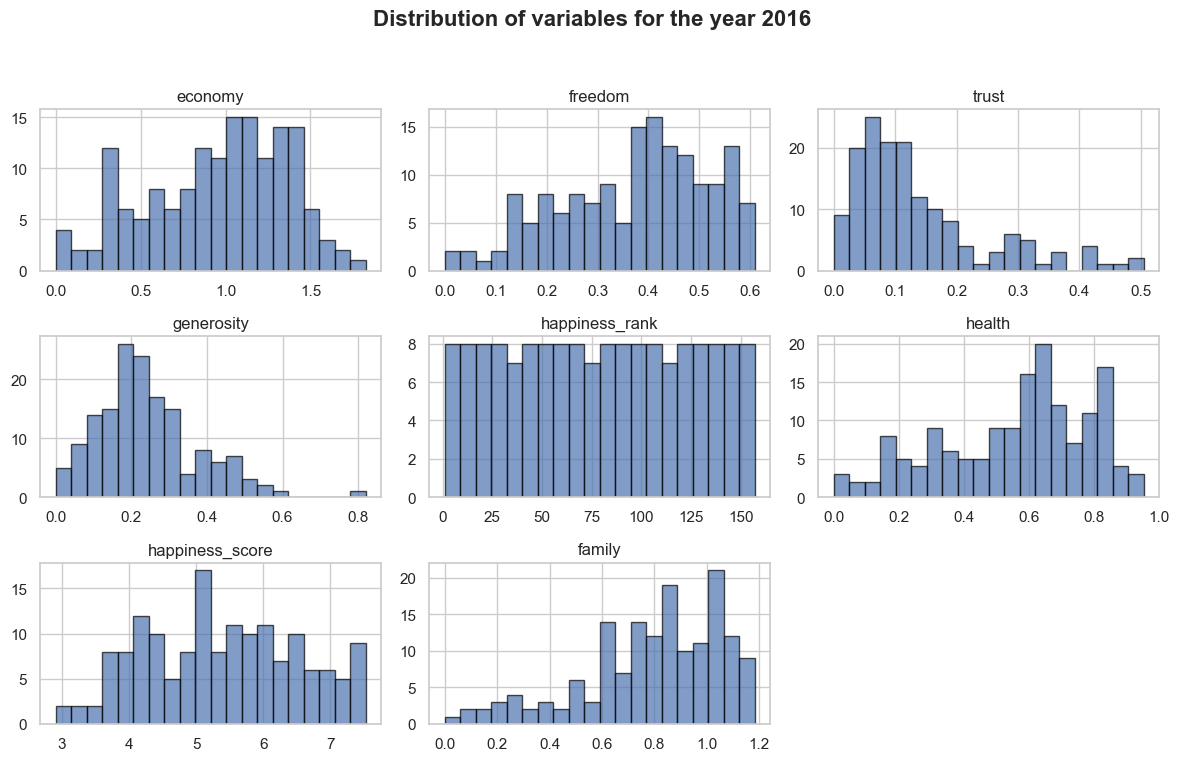

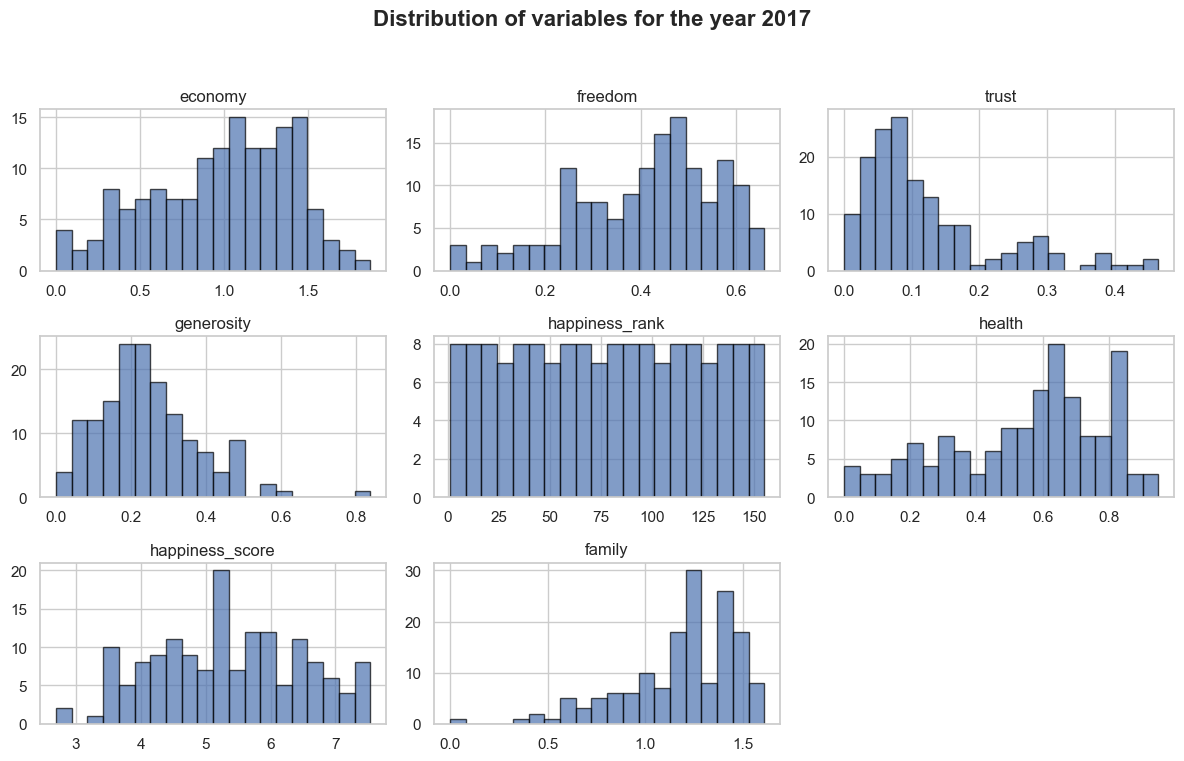

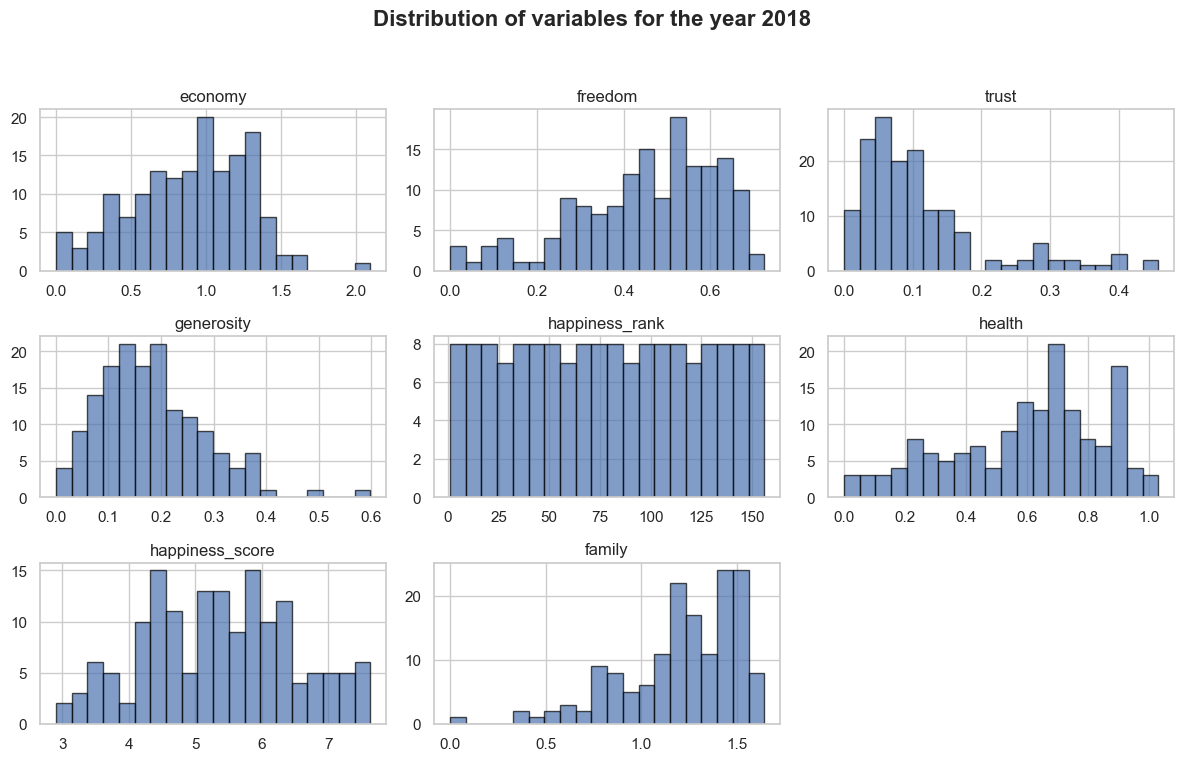

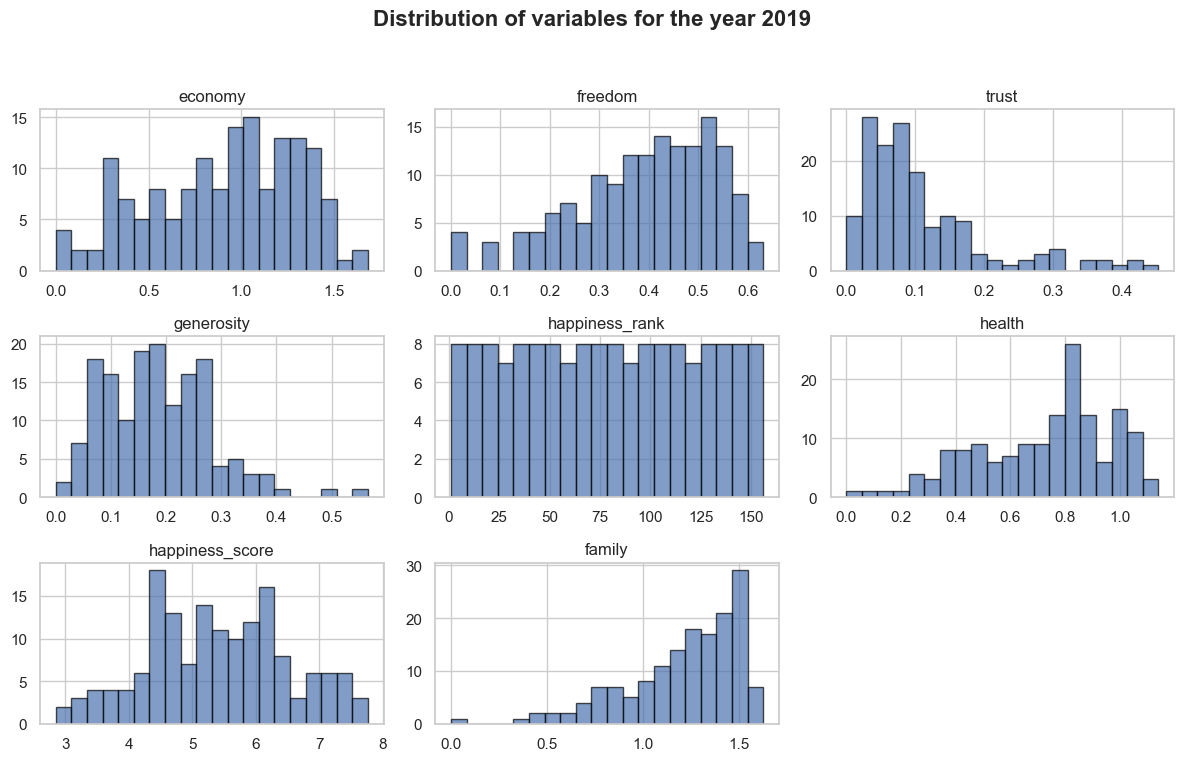

In [21]:
# Set aesthetic style for the plots
sns.set(style="whitegrid")  # Use a white background with grid lines for better readability
plt.rcParams["figure.figsize"] = (12, 8)  # Set default figure size for plots

# Iterate over the DataFrames
for year, df in dfs.items():
    # Select numeric columns for visualization
    df_numeric = df.select_dtypes(include=['number'])  # Filter only numerical columns

    # Generate histograms for all numeric columns
    df_numeric.hist(bins=20, edgecolor='black', alpha=0.7)  # Set number of bins and edge color for clarity

    # Add title and labels
    plt.suptitle(f"Distribution of variables for the year {year}", fontsize=16, fontweight='bold')  # Main title
    plt.xlabel('Value', fontsize=12)  # Label for x-axis
    plt.ylabel('Frequency', fontsize=12)  # Label for y-axis

    # Adjust layout to prevent overlapping elements
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  

    # Display the plot
    plt.show()

### **Handling Null Values**

Since the `trust` distribution for 2028 is right-skewed, the median is a more robust choice than the mean for imputing null values. In this case there is only one null value, and it will be handled by imputing the median.


In [22]:
#Calculate the median for 'trust' in 2018
median_trust_2018 = dfs['2018']['trust'].median()

# Imputing null values with the median
dfs['2018']['trust'].fillna(median_trust_2018, inplace=True)

# Verifying the presence of null values
print(dfs['2018']['trust'].isnull().sum())

0


### **Handling Outliers**

We're replacing outliers with the **median** because these values likely represent *extreme values*   that could distort the accuracy of predictive models. Here’s why this approach makes sense:

- **Median is robust to extreme values** → Unlike the mean, the median **does not shift due to outliers** and most distributions are skewed.
- **Preserves the central tendency** → Instead of deleting data, replacing outliers with the median keeps the distribution balanced.
- As seen in the distributions graphs,the distributions are mostly skewed so it is better to input the median.

In [23]:
def impute_outliers_with_median(df):
    """
    Detects and imputes outliers by replacing them with the column median.

    - Uses the IQR method to identify outliers.
    - Replaces outliers with the median of the respective column.

    Parameters:
    df (pd.DataFrame): DataFrame to process.

    Returns:
    pd.DataFrame: DataFrame with outliers replaced.
    """
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate quartiles and IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Compute median
        column_median = df[column].median()

        # Replace outliers with median
        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), column_median, df[column])

    return df

In [24]:
for year, df in dfs.items():
    dfs[year] = impute_outliers_with_median(df)

## Exploration through graphs

### **Correlation heatmap**

We are exploring correlations for each year trhough a heatmap.

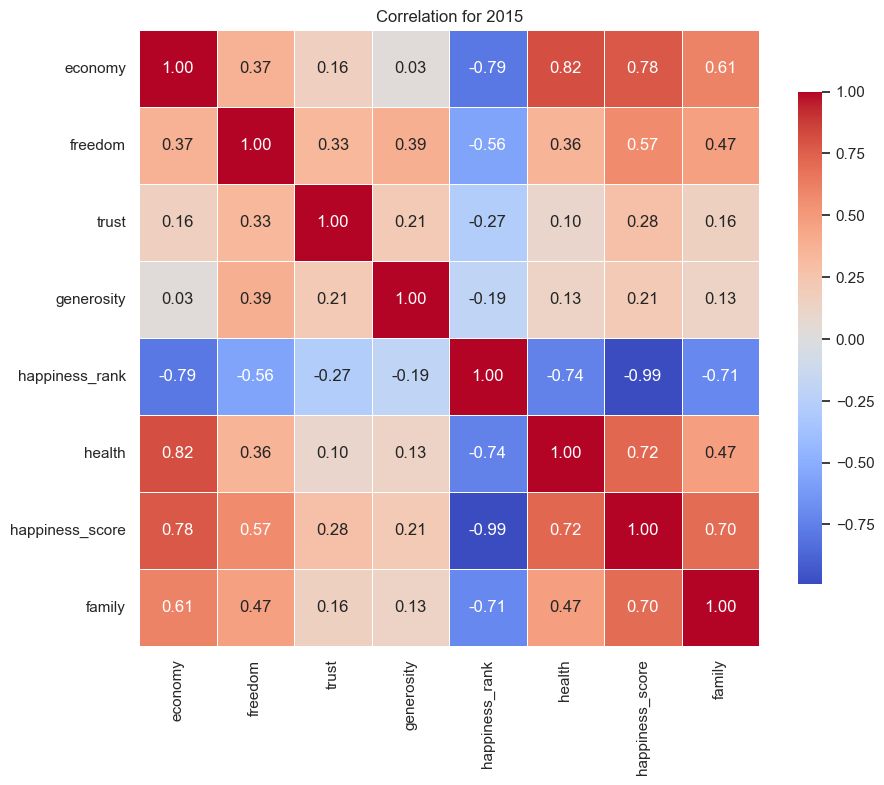

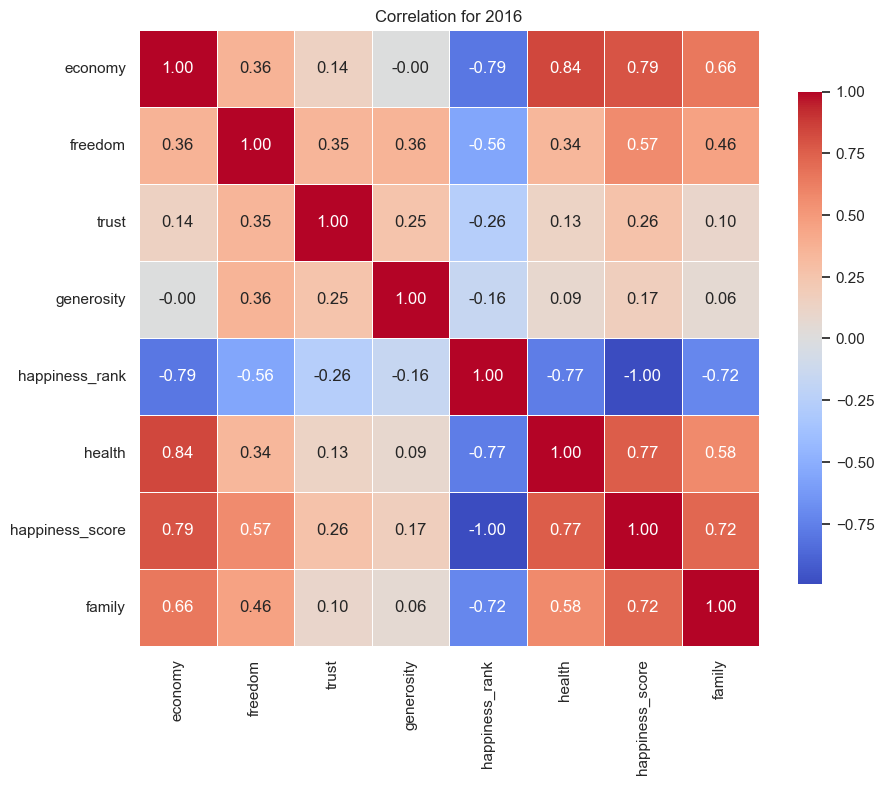

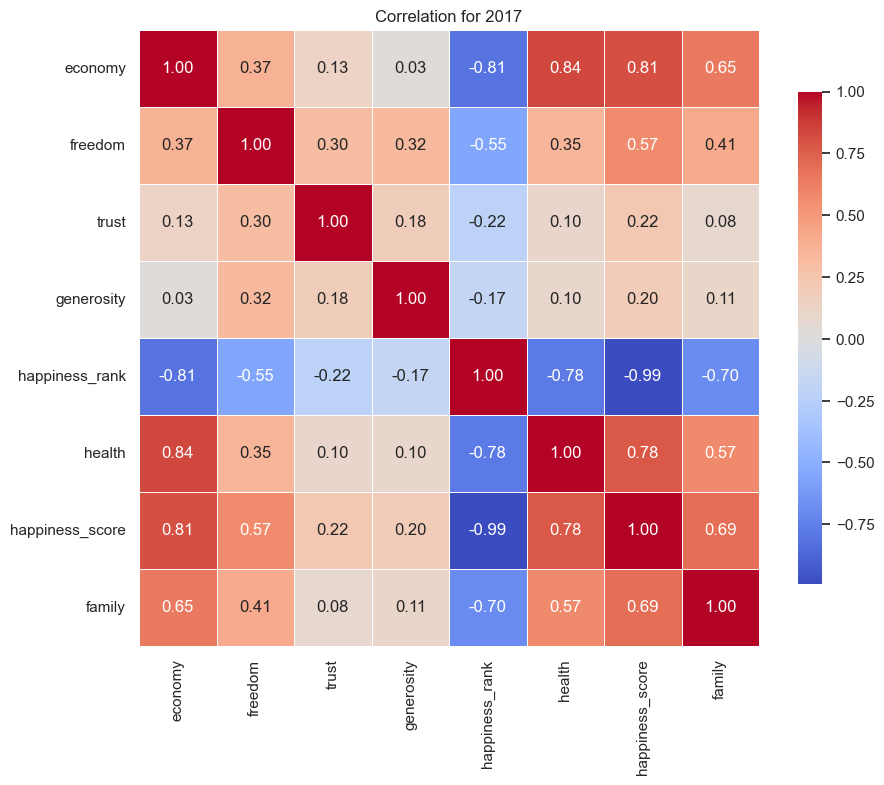

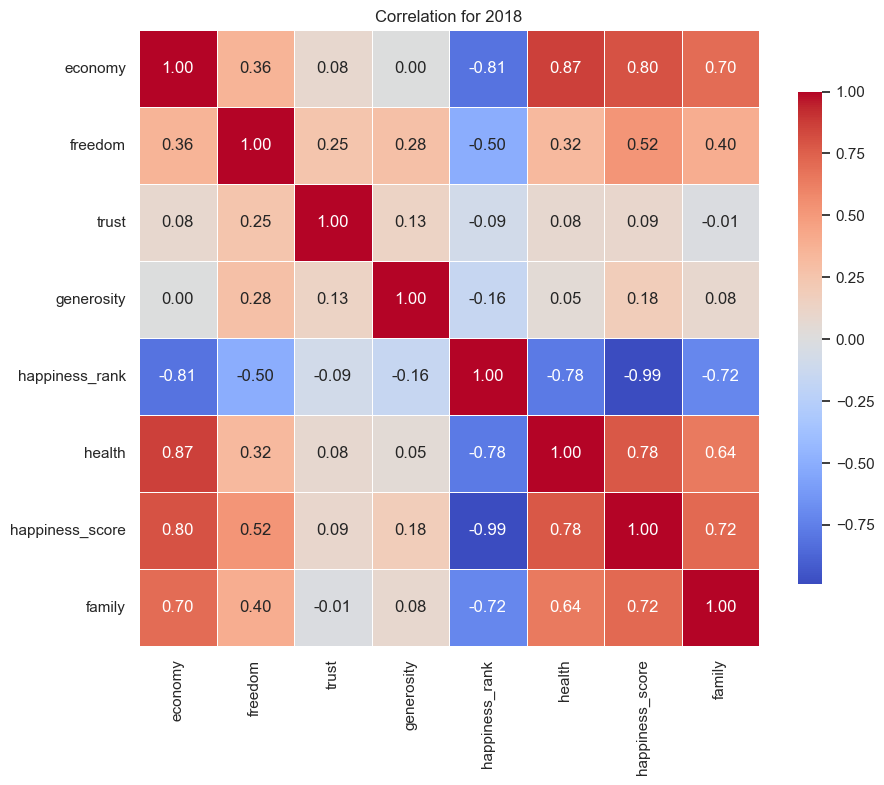

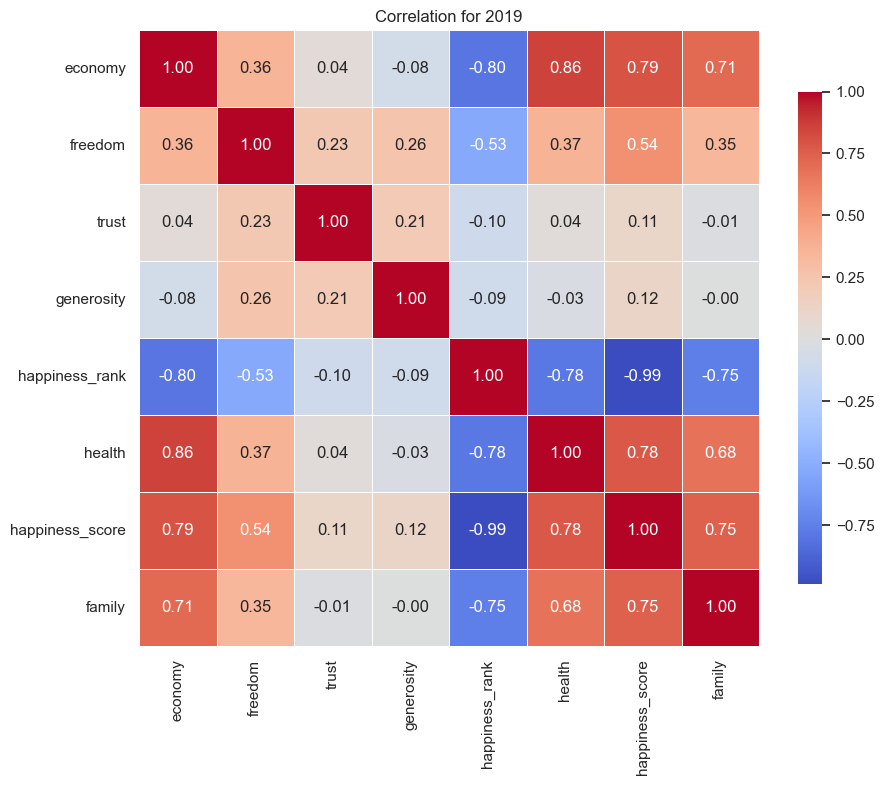

In [25]:
# Iterate over the DataFrames
for year, df in dfs.items():
    # Select only numeric columns (without removing the 'Country' column)
    df_numeric = df.select_dtypes(include=['number'])  # Filter out non-numeric data

    # Compute the correlation matrix for numeric columns
    corr = df_numeric.corr()  # Calculate correlation coefficients between variables

    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(10, 8))  # Set figure size for better readability
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})  # Heatmap with annotations

    # Set the title of the graph
    plt.title(f"Correlation for {year}")  # Display the year in the title
    plt.show()  # Show the plot

### **Scatterplots**

Analyzing the **target variable** (`happiness_score`) in relation to other features is crucial because it helps uncover patterns, correlations, and anomalies that could impact the predictive model’s performance. By visualizing relationships between numerical features and the target variable—such as through scatter plotswe can determine which features have significant influence on predictions. This step aids in identifying **predictive trends, outliers, and multicollinearity**, ensuring that only the most relevant features are used for training. 


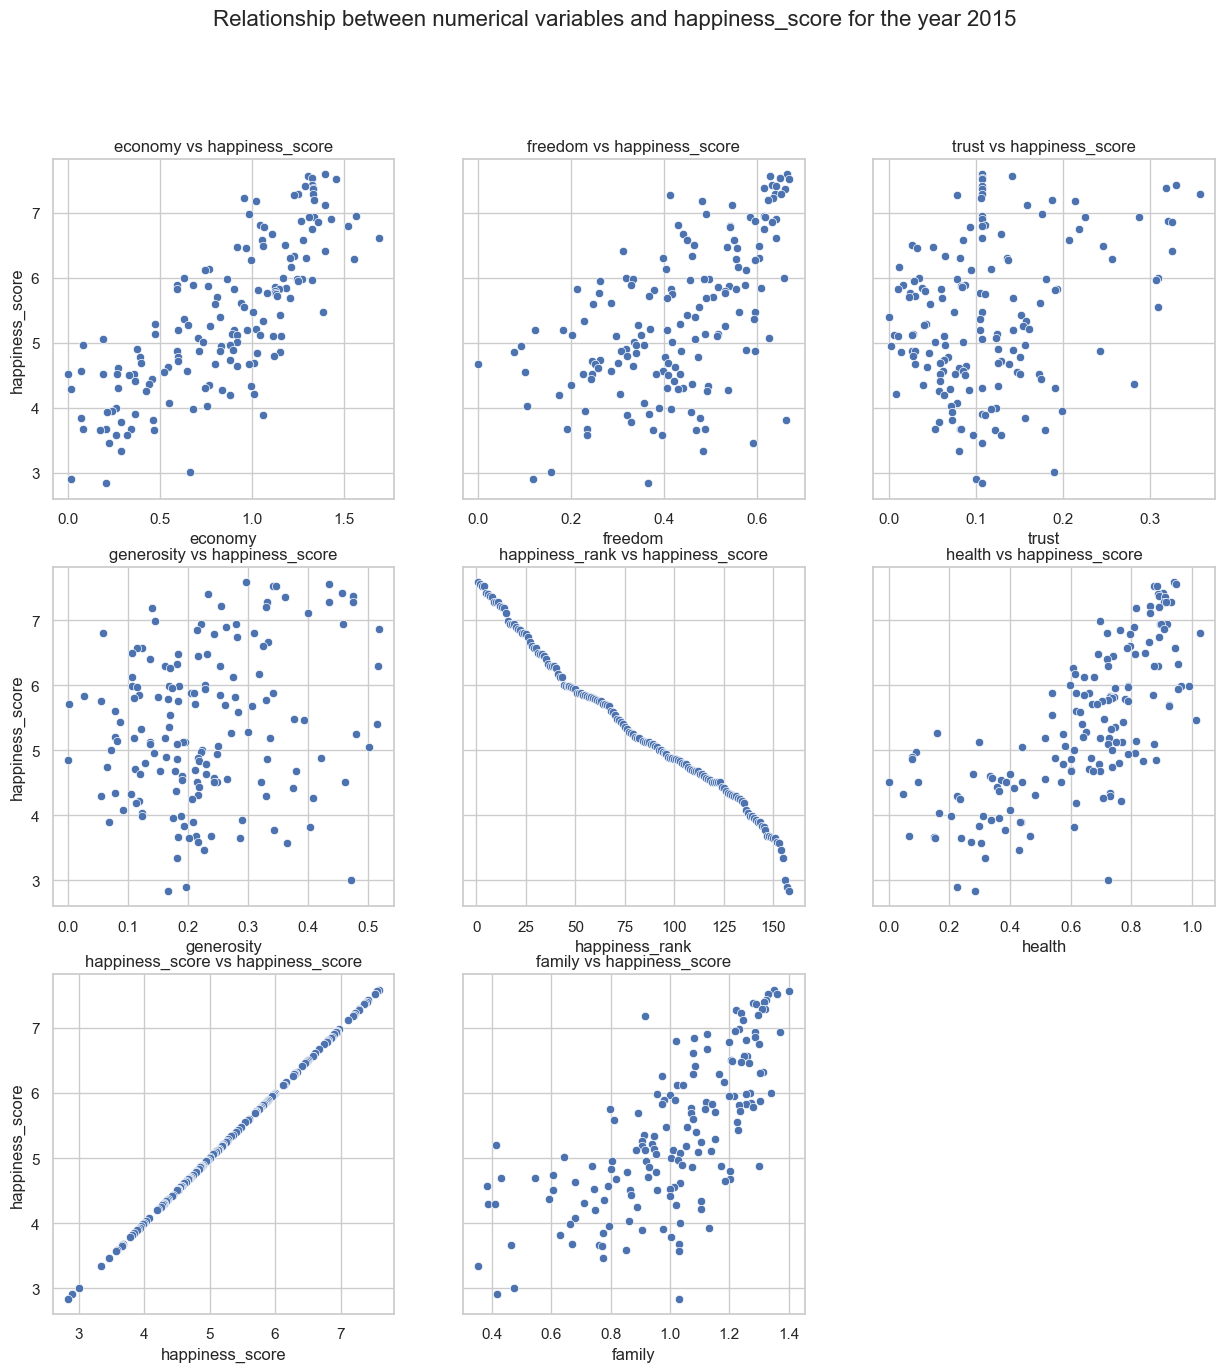

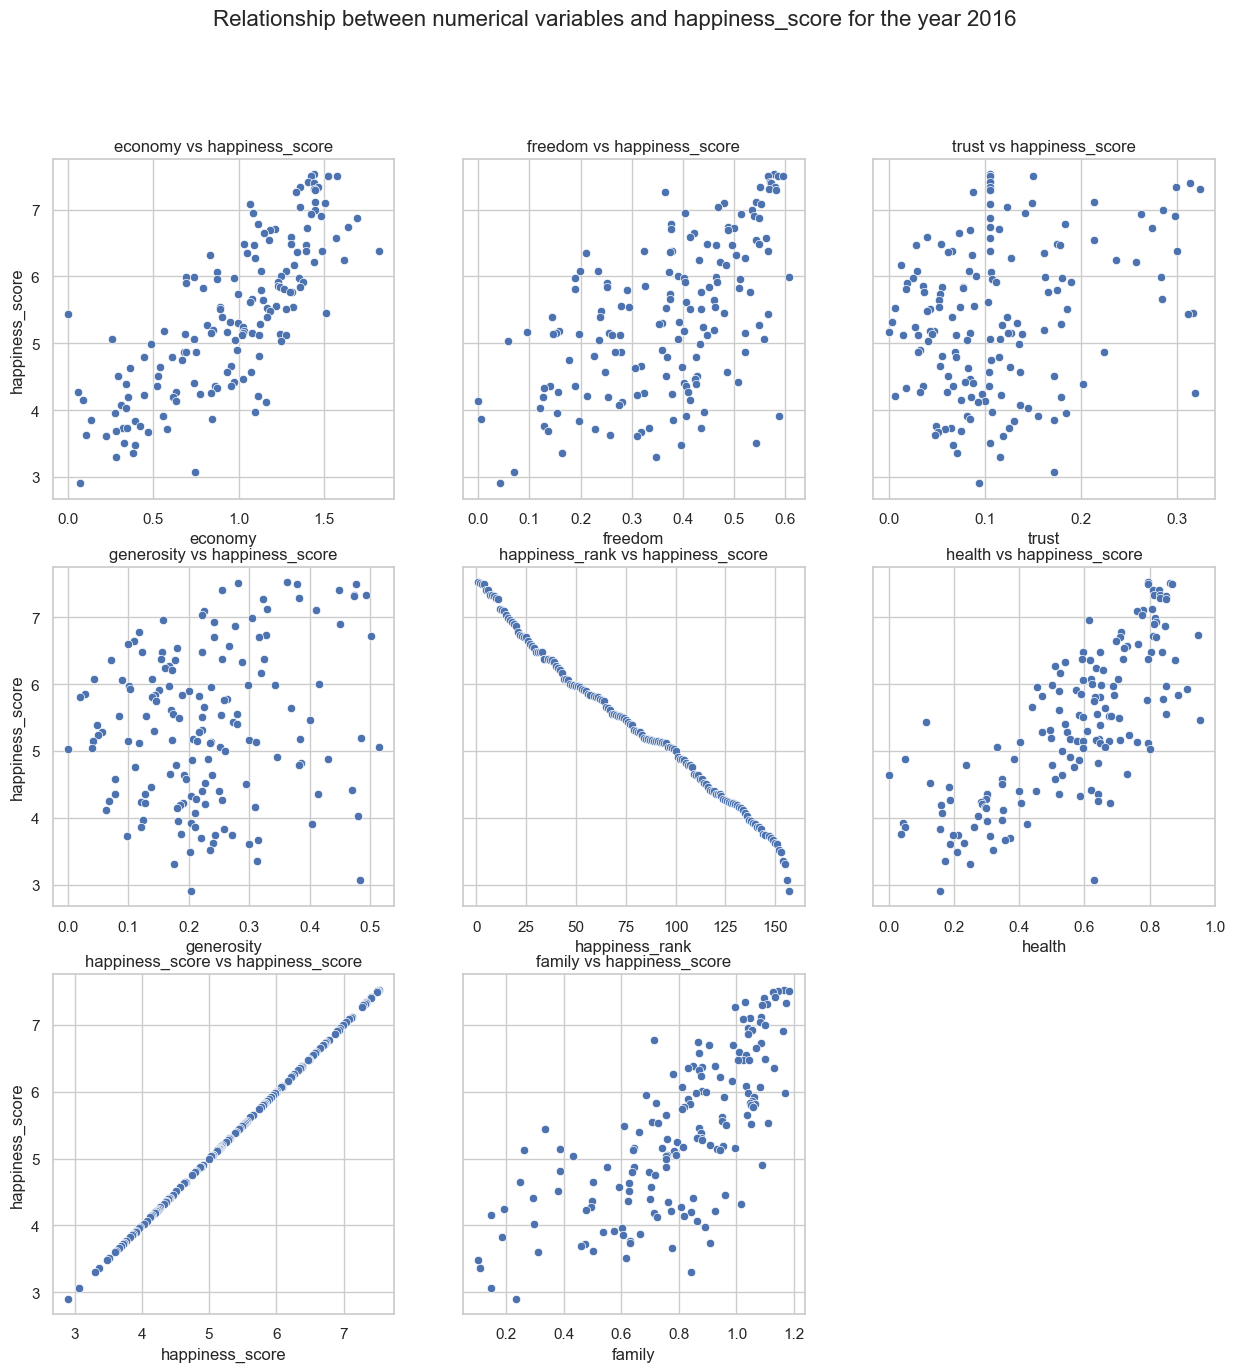

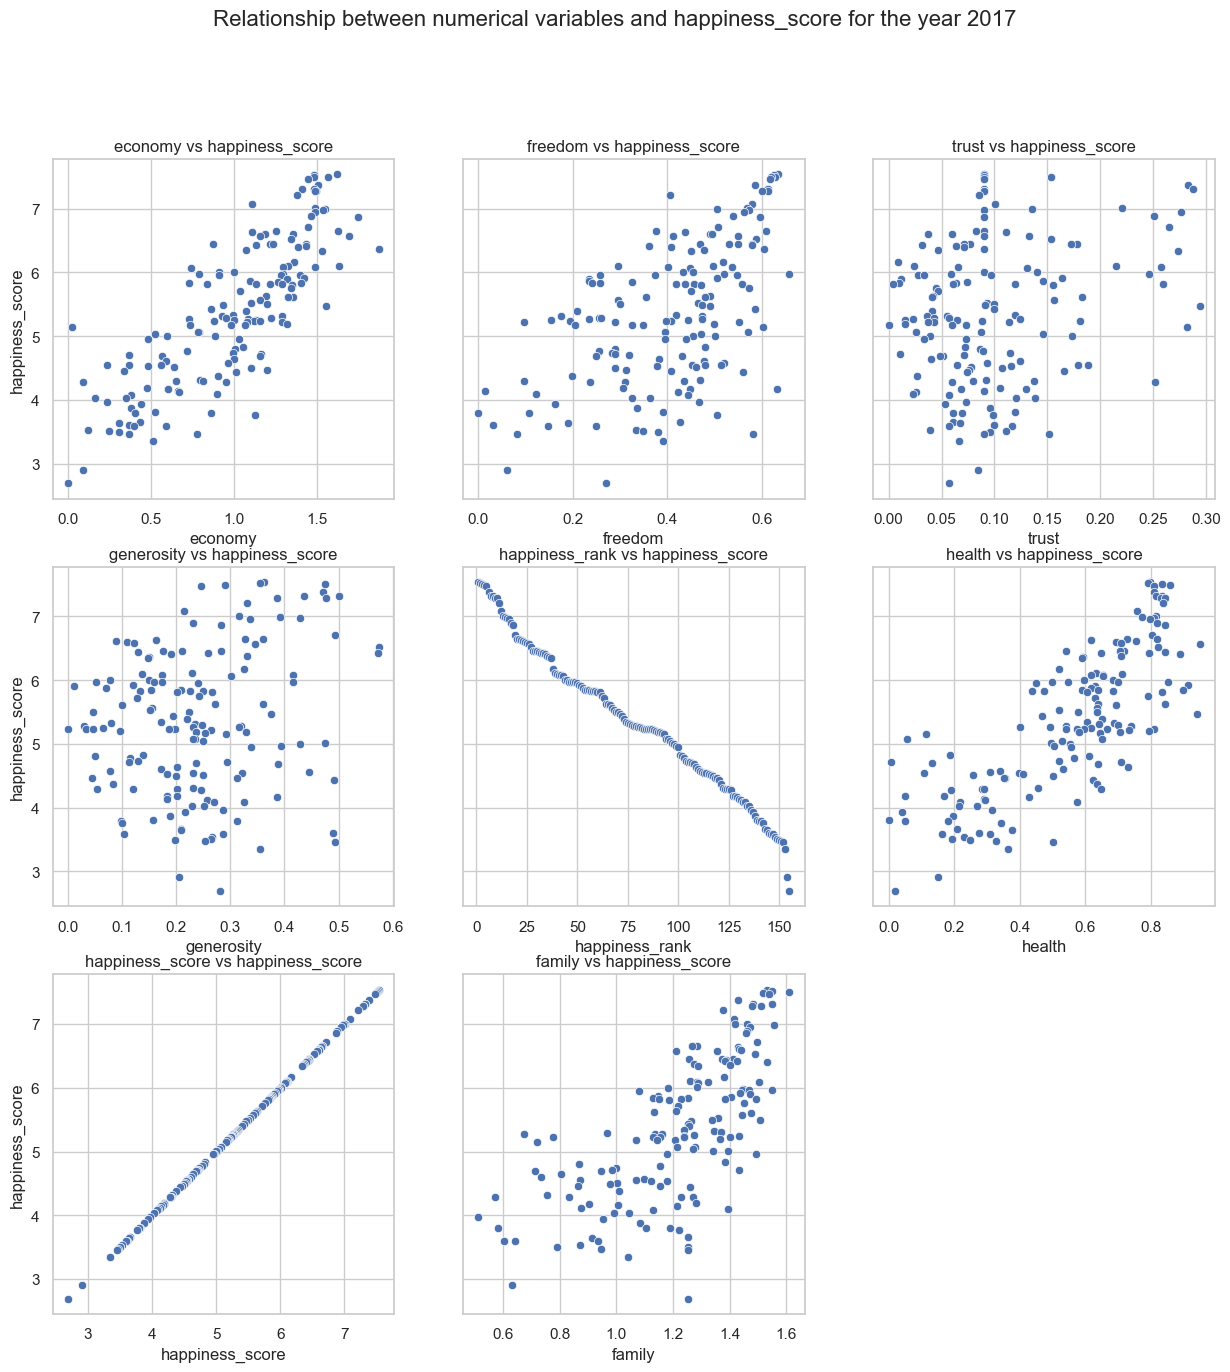

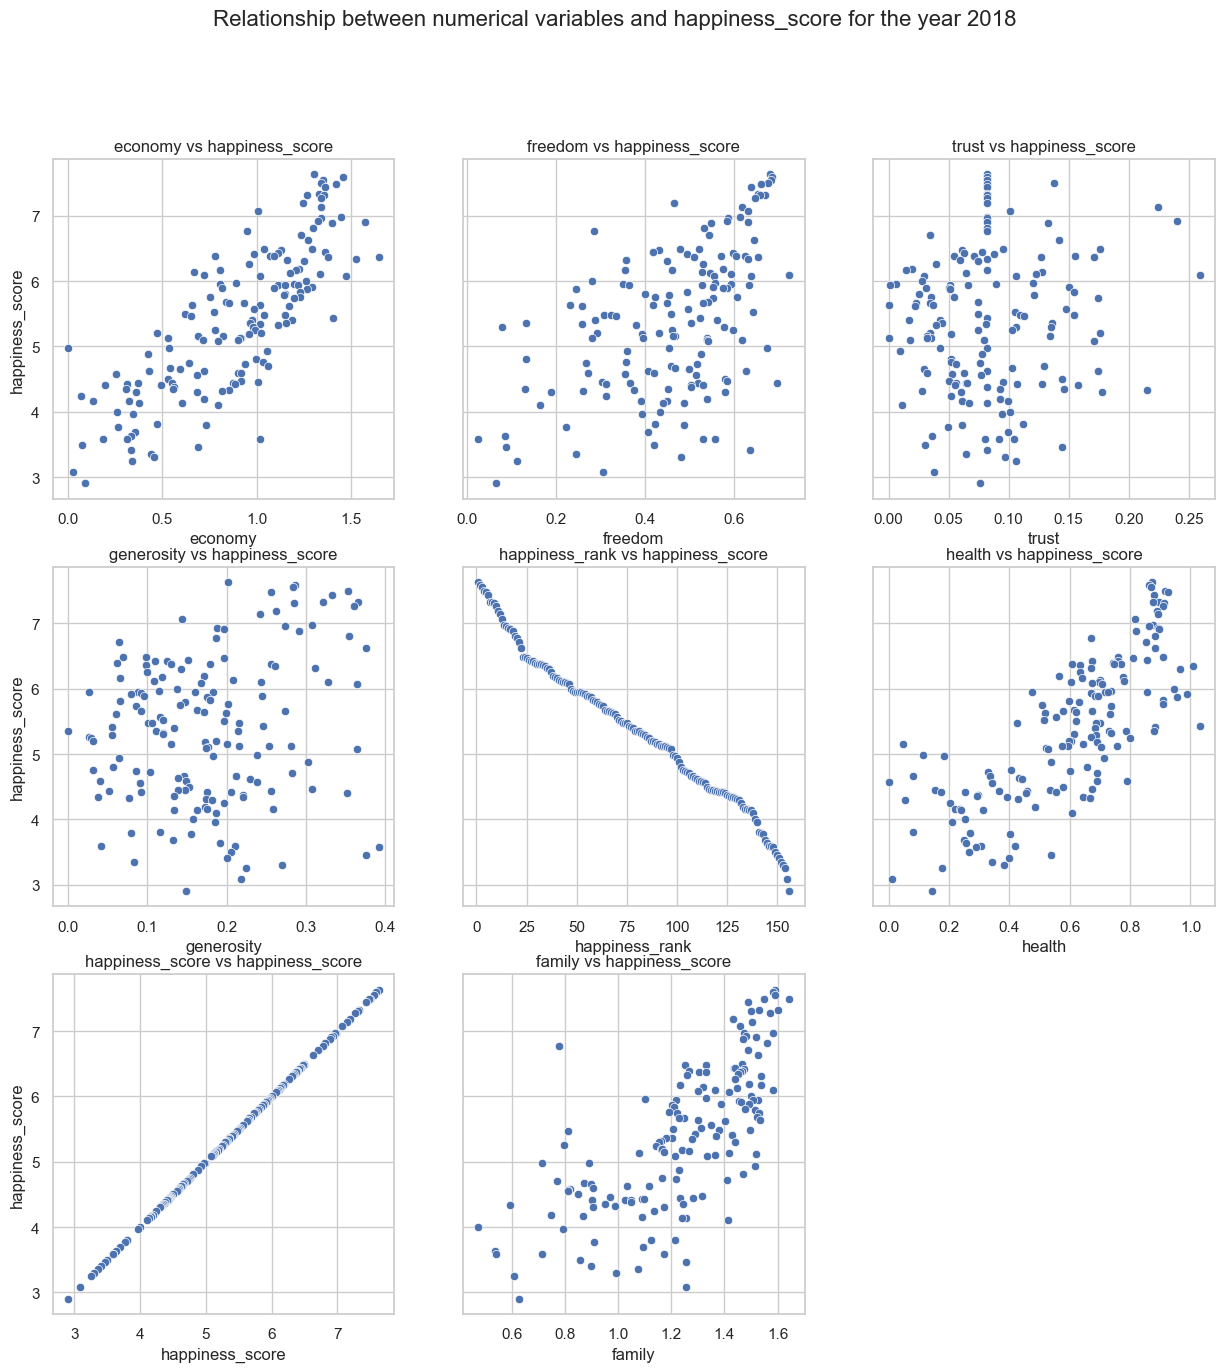

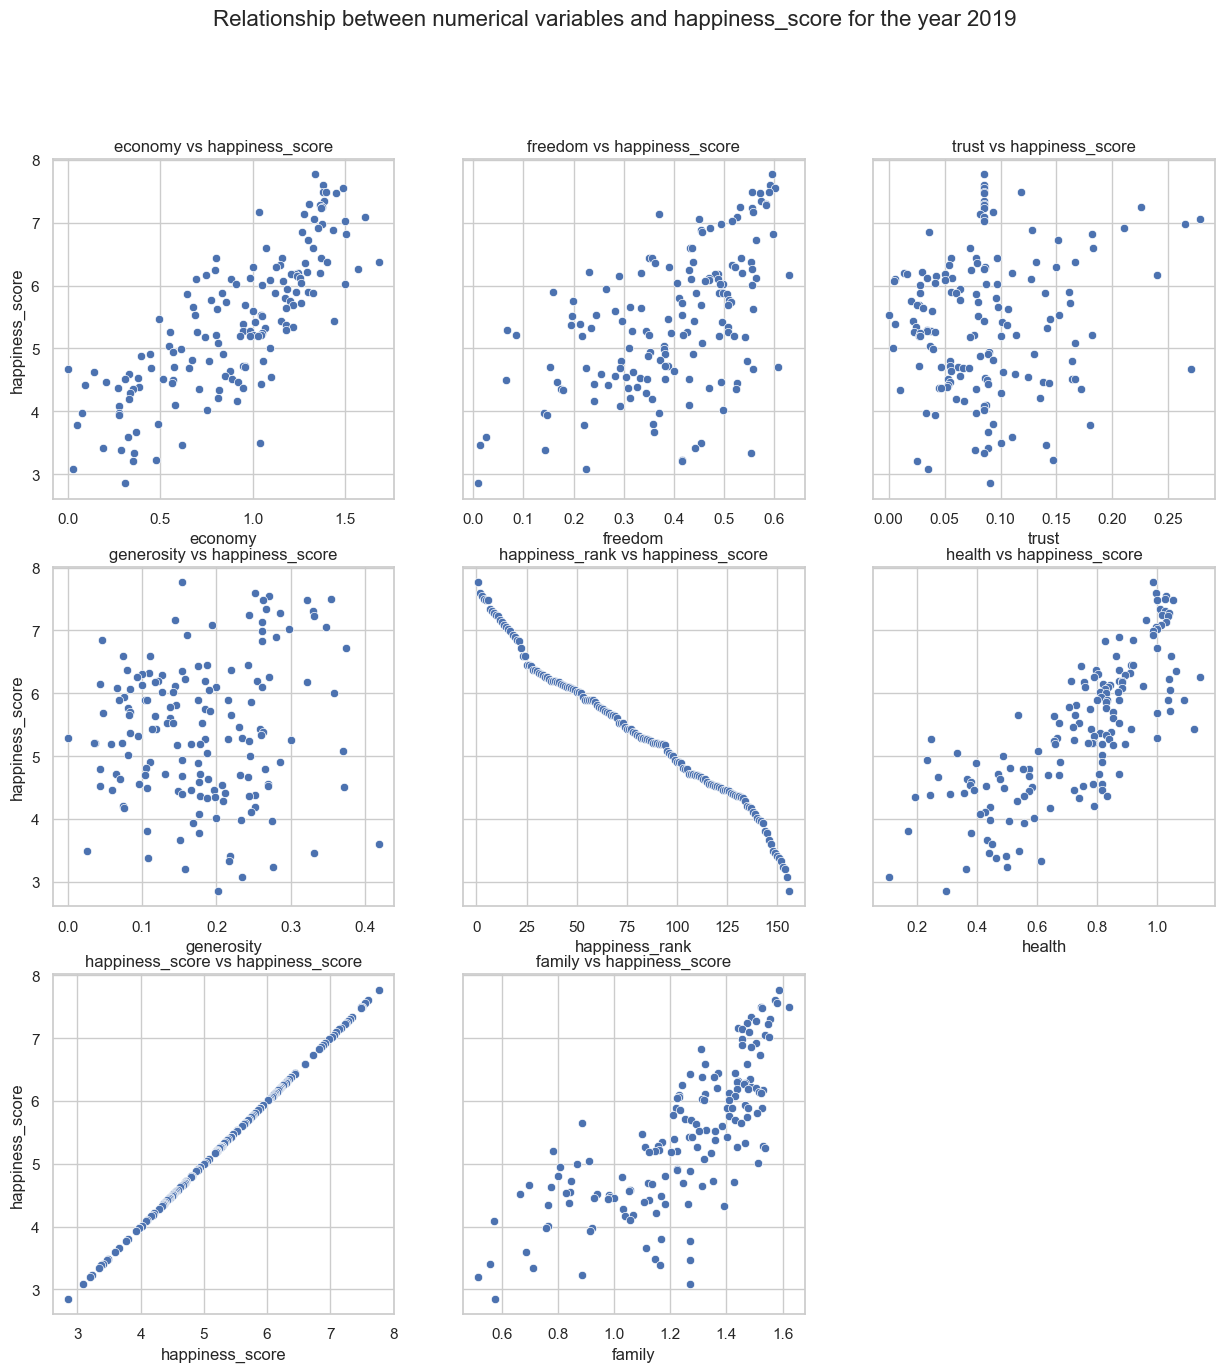

In [26]:
# Define the target column for analysis
target_column = 'happiness_score'  

# Iterate over the DataFrames
for year, df in dfs.items():
    # Select only numeric columns
    df_numeric = df.select_dtypes(include=['number'])  
    num_columns = len(df_numeric.columns)  # Count the number of numeric columns

    # Dynamically define the number of rows and columns for the subplot layout
    num_rows = int(np.ceil(num_columns / 3))  # Adjust based on the max number of columns per row
    num_cols = min(3, num_columns)  # Maximum of 3 columns per row for better organization

    # Create subplots dynamically based on the number of variables
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows), sharey=True)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Iterate over numeric columns and plot scatter plots in subplots
    for ax, column in zip(axes, df_numeric.columns):
        sns.scatterplot(x=df[column], y=df[target_column], ax=ax)  # Create scatter plot
        ax.set_title(f"{column} vs {target_column}")  # Add title
        ax.set_xlabel(column)  # Label x-axis

    # Hide unused axes in case there are fewer plots than allocated subplots
    for i in range(num_columns, len(axes)):  
        fig.delaxes(axes[i])  # Remove empty subplots for better visualization

    # Add a global title for the entire figure
    fig.suptitle(f"Relationship between numerical variables and {target_column} for the year {year}", fontsize=16)
    
    # Display the plots
    plt.show()

### **Scatterplots interpretation**

These scatterplots display the relationship between the target variable, `happiness_score`, and factors like freedom, economy, health, and family support (for each year).

- **Freedom vs Happiness Score:** A positive trend suggests that greater freedom is associated with higher happiness scores.
- **Economy vs Happiness Score:** A strong positive correlation is evident—countries with better economies tend to have happier populations.
- **Health vs Happiness Score:** A clear upward trend indicates that better health is linked to increased happiness, emphasizing the importance of physical well-being.
- **Family vs Happiness Score:** The data shows a positive correlation, reinforcing the emotional and social impact of family connections.

Regarding linearity:

- **Trust and Generosity** appear to have a more scattered pattern, suggesting they may not follow a strict linear relationship. While their impact on happiness is positive, the connection might be influenced by other factors or exhibit diminishing returns at higher levels.


As for the **negative correlation between rank and happiness score**, the relationship exists because the ranking system is in **descending order**—meaning:
- Countries with **higher happiness scores** are given **lower rank numbers** (closer to 1).
- Countries with **lower happiness scores** receive **higher rank numbers** (closer to last place).

This is an **inverse relationship**, but not necessarily an indication of causation—it's simply a **mechanical consequence** of how the ranking system is structured. If happiness scores were plotted against rank, the trend would slope downward, reinforcing that **as happiness increases, rank decreases**.

### **Q-Q plot**

In this case, a **Q-Q plot (Quantile-Quantile plot)** is used to evaluate whether the data for the target variable (`happiness_score`) follows a normal distribution.

#### **Why is checking for normality important?**

- Many Machine Learning algorithms, such as linear regression and some statistical methods, **assume that the data follows a normal distribution**.
- If the data **shows significant deviations**, it may be necessary to apply **transformations such as logarithms or scaling** to improve model accuracy.
- **Avoid bias and improve interpretability**: If the data is not normally distributed, some metrics like the mean and standard deviation can be misleading.
- **Identify outliers**: Points far from the reference line in a Q-Q plot may indicate extreme values that affect the model’s performance.

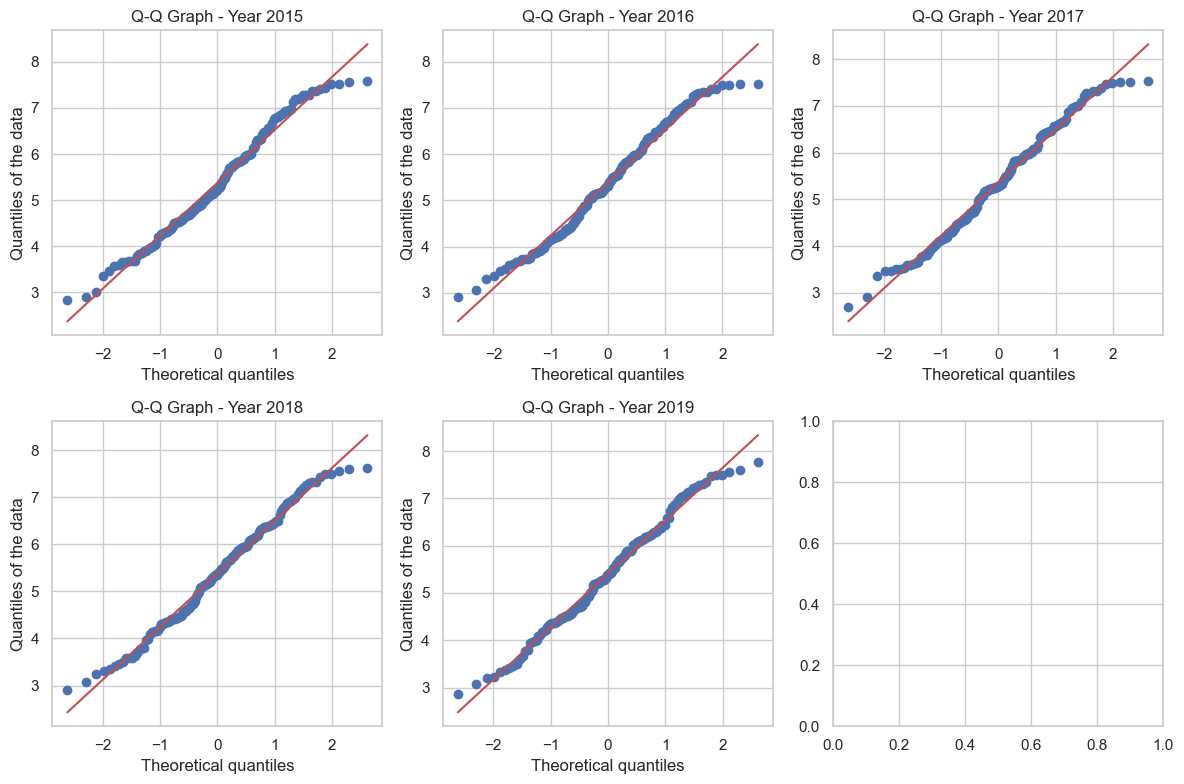

In [27]:
# Define the number of rows and columns for the subplot layout
num_rows = 2  # Number of rows in the figure
num_cols = 3  # Number of columns in the figure

# Create the figure with subplots to organize multiple plots in a single visualization
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

# Iterate through each DataFrame in the dictionary and plot in the correct position
for idx, (year, df) in enumerate(dfs.items()):
    row = idx // num_cols  # Calculate the correct row within the layout
    col = idx % num_cols   # Calculate the correct column within the layout

    column_name = "happiness_score"  # Define the target column (modify if necessary)
    data = df[column_name].dropna()  # Remove NaN values to prevent errors in analysis

    # Create a Q-Q plot in the corresponding subplot position
    stats.probplot(data, dist="norm", plot=axes[row, col])  # Compare data distribution to normality
    axes[row, col].set_title(f"Q-Q Graph - Year {year}")  # Set title for the plot
    axes[row, col].set_xlabel("Theoretical quantiles")  # Label for the x-axis
    axes[row, col].set_ylabel("Quantiles of the data")  # Label for the y-axis

# Adjust layout to prevent overlapping of plots and improve readability
plt.tight_layout()
plt.show()

### **Q-Q plots interpretation** 

The Q-Q plots for each year (2015–2019) compare the quantiles of the dataset against a theoretical normal distribution, helping assess whether the target variable (`happiness_score`) follows normality. 

- **General trend:** The blue dots closely align with the red line in the middle range of each plot, suggesting the data follows a normal distribution fairly well in that region.
- **Deviations at the tails:** In all years, there are deviations at the lower and upper extremes—some points stray above or below the red line. This indicates that the dataset may have heavier or lighter tails than expected under normality, possibly suggesting skewness or kurtosis effects.
- **Consistency across years:** The patterns appear fairly stable, meaning the distribution characteristics did not change drastically from year to year.
- **Empty sixth plot:** It does not contain any data, so it does not contribute to the analysis.

Overall, these plots suggest the data is approximately normal but may exhibit slight deviations at the tails.

### **Skewness and Kurtosis**

The analysis of **skewness and kurtosis** is crucial in our  **Exploratory Data Analysis (EDA)** because it helps understand the distribution of the target variable (`happiness_score`) before applying Machine Learning models.


1. **Understanding Data Distribution:**  
   - **Skewness** indicates whether the data is **leaning toward lower or higher values**, which can impact the interpretation of central tendency metrics like the mean and median.
   - **Kurtosis** provides insight into whether the dataset has **extreme values (long tails) or is more uniformly distributed**.

2. **Avoiding Issues in Model Performance:**  
   - **Highly skewed distributions** can mislead the model and cause biased learning.
   - **High kurtosis may indicate outliers**, which can lead to instability in Machine Learning algorithms.

3. **Deciding on Data Transformations:**  
   - If **skewness is excessive**, transformations like **logarithms, square root, or Box-Cox** can help normalize the distribution.
   - If **kurtosis is high**, handling extreme values may be necessary before training the model.


In [28]:
# Create a list to store results for each year
results = []

# Calculate skewness and kurtosis for each year
for year, df in dfs.items():
    data = df["happiness_score"].dropna()  # Remove NaN values to avoid errors in calculations

    skewness = skew(data)  # Compute the skewness of the distribution
    kurt = kurtosis(data)  # Compute the kurtosis (shape of the distribution)

    # Interpretation of skewness
    skew_interpretation = "Slight right skew" if skewness > 0 else "Slight left skew" if skewness < 0 else "Approximately symmetric"

    # Interpretation of kurtosis
    kurt_interpretation = "High kurtosis (extreme values)" if kurt > 3 else "Low kurtosis (uniform distribution)"

    # Append results to the list
    results.append([year, round(skewness, 4), round(kurt, 4), skew_interpretation, kurt_interpretation])

# Convert the list into a DataFrame for better visualization
table = pd.DataFrame(results, columns=["Year", "Skewness", "Kurtosis", "Skewness Interpretation", "Kurtosis Interpretation"])

# Display the table with the analysis for each year
table

,Year,Skewness,Kurtosis,Skewness Interpretation,Kurtosis Interpretation
0,2015,0.0968,-0.7895,Slight right skew,Low kurtosis (uniform distribution)
1,2016,0.0433,-0.8999,Slight right skew,Low kurtosis (uniform distribution)
2,2017,0.0095,-0.7649,Slight right skew,Low kurtosis (uniform distribution)
3,2018,0.0150,-0.7264,Slight right skew,Low kurtosis (uniform distribution)
4,2019,0.0113,-0.6273,Slight right skew,Low kurtosis (uniform distribution)


### **Skewness & Kurtosis Interpretation**

1️⃣ **Skewness** is **very low** across all years, meaning the distribution is **almost symmetric**, with only a slight rightward bias.  
2️⃣ **Kurtosis** is **negative** in all cases, indicating that the distribution is **platykurtic** (flatter and with fewer extreme values). This suggests that the data is more concentrated around the mean, without long tails.  

**How does this affect model selection?**  
- Since **there is no strong skew**, it is unnecessary to use models that correct extreme asymmetry (such as Gamma or logit).  
- Low kurtosis indicates **moderate data variability**, which may favor a **standard linear model**.  
- If values are restricted between **0 and 10**, a **Beta Regression** (with Min-Max Scaling transformation) could be a good option.  
- We can also try a **Classic Linear Regression** or a **GLM with identity function**, as the distribution appears quite stable. 

### **VIF and Tolerance**

Variance Inflation Factor (VIF) and Tolerance are essential because they help detect multicollinearity among numerical predictors. Multicollinearity occurs when independent variables are highly correlated, which can distort the predictive power and stability of machine learning models.


In [29]:
# Iterate over each year and calculate VIF and Tolerance for numeric predictors (excluding 'Happiness Score')
for year, df in dfs.items():
    # Select numeric columns and drop rows with missing values
    predictors = df.select_dtypes(include=["number"]).dropna()
    
    # Remove 'Happiness Score' if it exists
    predictors = predictors.drop(columns=["happiness_score"], errors="ignore")
    
    # Skip if not enough variables left
    if predictors.shape[1] < 2:
        print(f"\n⚠️ Not enough numeric variables to compute VIF for the year {year}.")
        continue

    # Compute VIF and Tolerance
    vif_data = pd.DataFrame()
    vif_data["Variable"] = predictors.columns
    vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
    vif_data["Tolerance"] = 1 / vif_data["VIF"]
    
    print(f"\n📊 VIF and Tolerance for the year {year} (excluding 'Happiness Score')")
    print(vif_data.round(3))



📊 VIF and Tolerance for the year 2015 (excluding 'Happiness Score')
         Variable     VIF  Tolerance
0         economy  22.759      0.044
1         freedom  14.864      0.067
2           trust   3.623      0.276
3      generosity   6.247      0.160
4  happiness_rank   3.099      0.323
5          health  22.315      0.045
6          family  23.576      0.042

📊 VIF and Tolerance for the year 2016 (excluding 'Happiness Score')
         Variable     VIF  Tolerance
0         economy  26.562      0.038
1         freedom  12.040      0.083
2           trust   3.806      0.263
3      generosity   6.006      0.167
4  happiness_rank   2.474      0.404
5          health  23.562      0.042
6          family  18.435      0.054

📊 VIF and Tolerance for the year 2017 (excluding 'Happiness Score')
         Variable     VIF  Tolerance
0         economy  29.170      0.034
1         freedom  12.507      0.080
2           trust   3.603      0.278
3      generosity   5.554      0.180
4  happiness_ran

###  **Variables with Severe Multicollinearity**

Generally, a **VIF > 10** (or Tolerance < 0.1) indicates **high multicollinearity**, which can distort regression model coefficients.

The following variables consistently show **severe multicollinearity across all years**:

| Variable    | Comment                                   |
|------------|-------------------------------------------|
| **family**  | VIF between 21 and 39. The worst case.   |
| **economy** | Very high VIF (23–31), worst in 2017.    |
| **health**  | VIF between 22 and 34. Also highly collinear. |
| **freedom** | Elevated VIF (12–15), but less critical. |

---

### ✅ **Variables with Acceptable Multicollinearity**

The following variables maintain a reasonable VIF (usually < 5):

| Variable            | VIF Range | Comment                         |
|--------------------|----------|--------------------------------|
| **happiness_rank** | 2.3 – 3.3 | Very acceptable.               |
| **generosity**     | 5.1 – 5.6 | Slightly high but manageable.  |
| **trust**         | 3.4 – 3.7 | Not a serious problem.        |


### **Let´s review the correlation matrix again to decide how to handle multicollinearity**



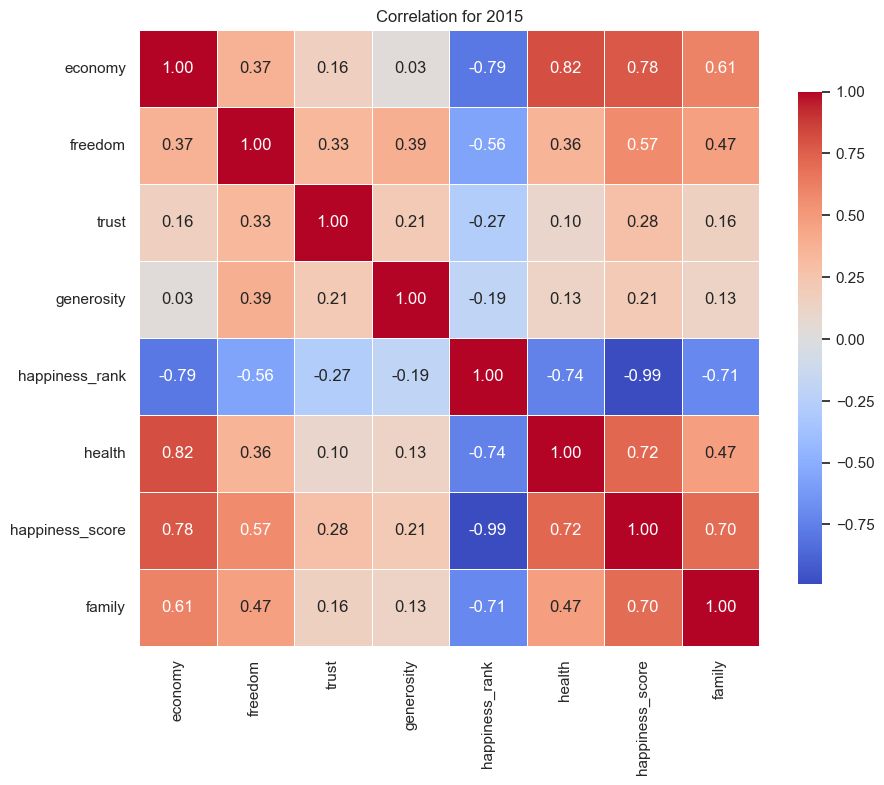

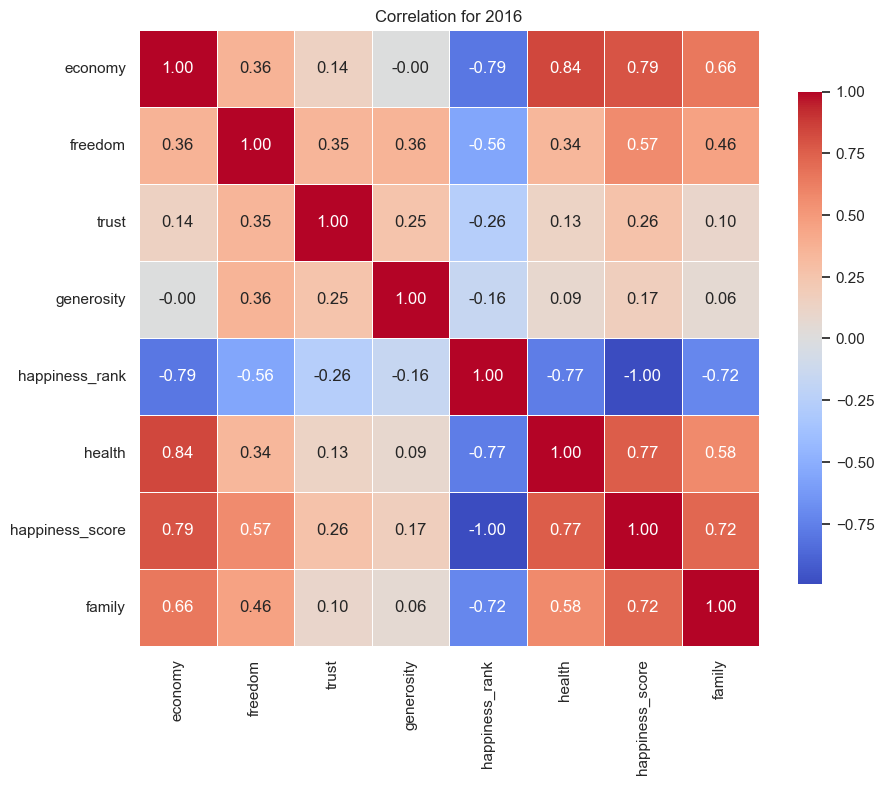

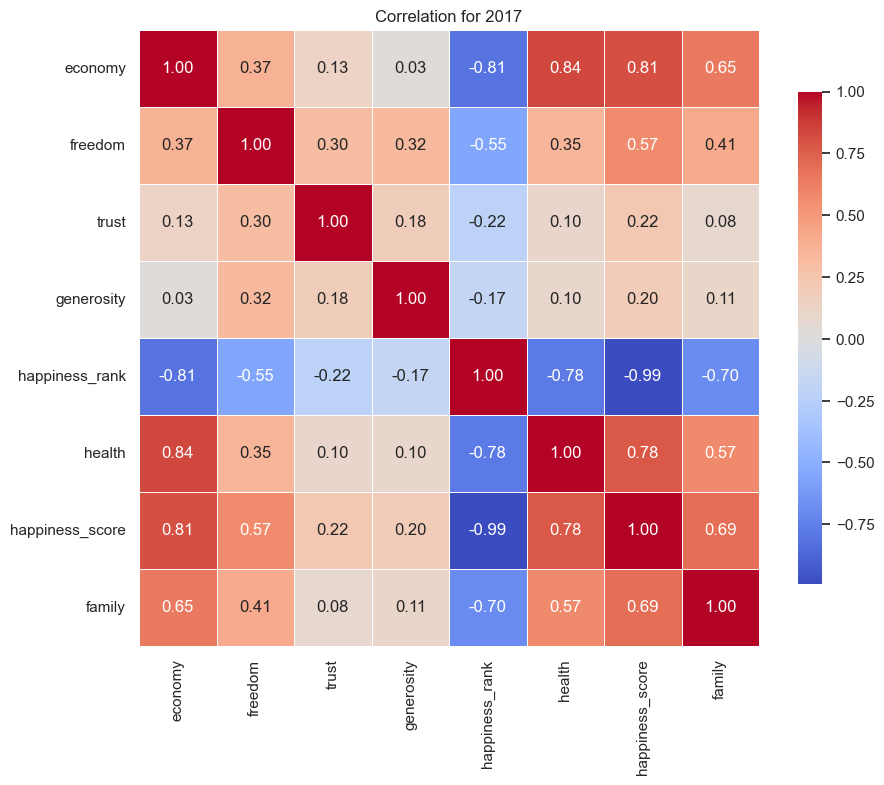

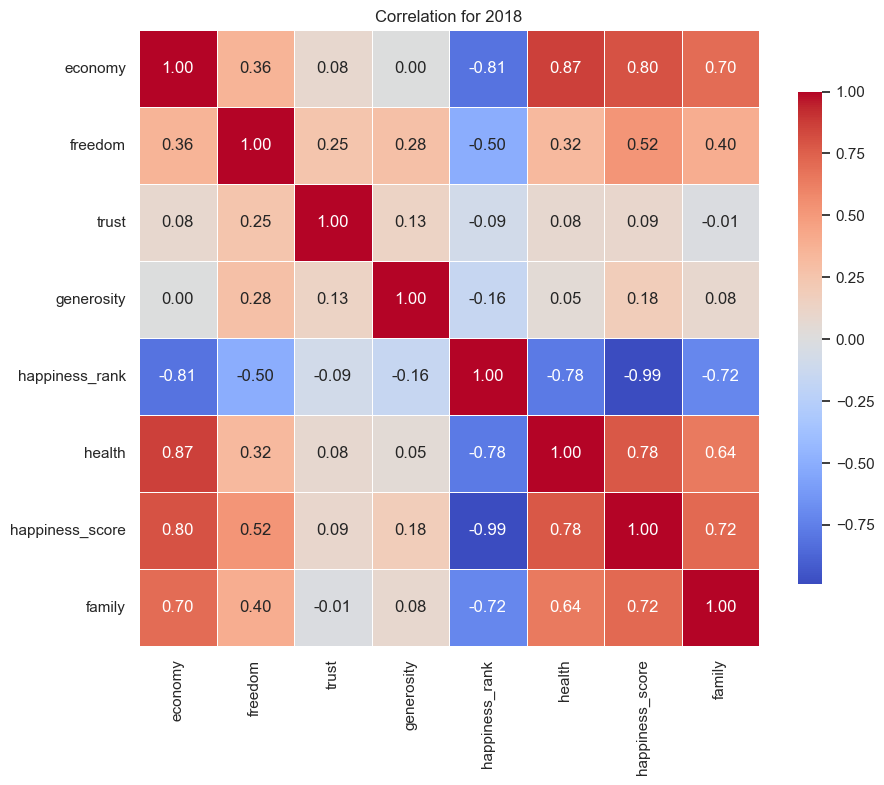

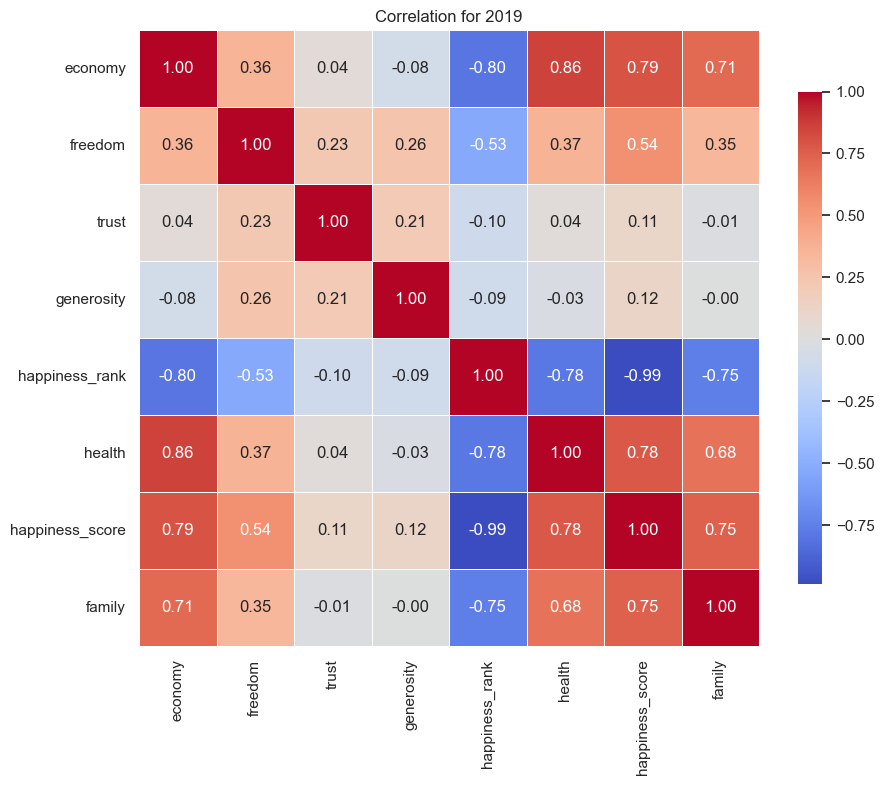

In [30]:
for year, df in dfs.items():

    df_numeric = df.select_dtypes(include=['number'])

    corr = df_numeric.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})

    plt.title(f"Correlation for {year}")
    plt.show()

### **Collinearity Analysis**

From th **correlation heatmaps**, we can confirm what the VIF values already indicated: there's strong multicollinearity among several predictors, especially those related to general well-being:

* `economy` and `health`
* `economy` and `family`
* `family` and `health`
* All three are also strongly correlated with `happiness_score`.


In this case of highly correlated variables ( `economy`, `health`, `family`), we could use the following strategy:


**Keep only one representative variable**

Use one variable as a **proxy** for the group. For example:

* `economy` could represent the group since it has the **highest correlation with `happiness_score` (0.78)**.
* Alternatively, as our analysis focuses on social aspects, we might keep `family` or `health`.

## **Conclusions**

In a **linear model**, ideally, we should use variables that exhibit a **linear relationship** with the target variable because linear regression assumes a linear dependency between predictors and the response. However, there are **ways to handle non-linearity** rather than just excluding those variables, like:


**Trying Non-Linear Models**  
   - If linear transformations don't work, we could consider **non-linear regression models** such as **Decision Trees, Random Forests, or Neural Networks**, which can capture more complex relationships.


So, our options to model our predictions are as follows:


## 🎯 **1. Generalized Linear Models (GLM)**  

| GLM Model                         | When to Use It                                                  |  
|------------------------------------|----------------------------------------------------------------|  
| **Linear Regression (OLS)**        | When the relationship is linear and residuals are normally distributed |  
| **GLM Gaussian (Identity Link)**   | Similar to OLS but more flexible (better handling of heteroscedasticity) |  
| **GLM Gamma (Log Link)**           | If the target variable is positive and right-skewed           |  
| **GLM Beta (Logit/Probit Link)**   | If the target is in (0,1) → requires scaling `happiness_score` |

---

## 🤖 **2. Supervised Machine Learning Models**  

| Model                                              | Main Advantages                                       | Considerations                         |  
|---------------------------------------------------|------------------------------------------------------|-----------------------------------------|  
| **Random Forest Regressor**                         | Robust, handles non-linearities, variable importance | Less interpretable                      |  
| **Gradient Boosting (XGBoost, LightGBM, CatBoost)** | High accuracy, excellent for tabular data            | Can overfit if not regularized           |  
| **Support Vector Regression (SVR)**                 | Useful when data doesn't have a clear linear form    | Sensitive to scaling                     |  
| **k-Nearest Neighbors (KNN)**                       | Simple and non-parametric                            | Requires scaling, sensitive to noise     |  
| **MLP Regressor (Neural Network)**                  | Learns complex relationships                        | Needs more data and fine-tuning          |  



## 🧪 **3. Regularized Models**  

| Model               | When to Use It                             |  
|--------------------|------------------------------------------|  
| **Ridge Regression** | When there is moderate multicollinearity  |  
| **Lasso Regression** | For automatic variable selection         |  
| **ElasticNet**       | Balanced combination of Ridge and Lasso  |  

---

## ✅ **Which One to Choose Based on our Case?**  

Given that:  

* Our variable is in the range \[0,10] because the **happiness ranking (score)** is derived from the **Cantril Ladder**, which measures life evaluation on a **0-10 scale**. A standard linear regression **may not be the best choice**, as it can predict values outside this interval.
* **Skewness ≈ 0** and **Kurtosis ≈ negative**  
* We want to interpret results and possibly explain happiness  

### 🔵 **Use as a baseline:**  
* `LinearRegression` or `GLM Gaussian`  
* If multicollinearity exists: try `Ridge` or `Lasso`  

### 🔴 **Higher accuracy:**  
* `RandomForestRegressor`  
* `XGBoostRegressor`  

### 🟢 **If we want a bounded distribution:**  
* `Beta Regression` (rescaling target between 0 and 1)  


## **Concatenating Dataframes**

In [31]:
print(type(dfs))

<class 'dict'>


In [32]:
# Create an empty list to store DataFrames
df_list = []

# Iterate through each DataFrame in `dfs` and add the 'year' column
for year, df in dfs.items():
    df["year"] = year  # Add year column
    df_list.append(df)  # Store modified DataFrame

# Concatenate all DataFrames into a single one
df_final = pd.concat(df_list, ignore_index=True)


In [33]:
# Drop specified columns from df_final
df_final = df_final.drop(columns=["happiness_rank"])

## **Feature engineering**

### **Lagged features**

For each country, we create lagged versions of features (e.g., Economy_t-1 from the previous year) to capture temporal trends.

So we compute year-over-year changes (e.g., Economy_diff = Economy_t - Economy_t-1) to capture trends or shocks.

In [34]:
df_final.sort_values(by=["country", "year"], inplace=True)

In [35]:
# Define numerical columns to lag (excluding categorical ones like "year" and "country")
features_to_lag = [col for col in df_final.select_dtypes(include=[np.number]).columns if col != "year"]

# Generate lagged features (_t-1)
for feature in features_to_lag:
    df_final[f"{feature}_t-1"] = df_final.groupby("country")[feature].shift(1)

In [36]:
for feature in features_to_lag:
    df_final[f"{feature}_diff"] = df_final[feature] - df_final[f"{feature}_t-1"]

In [37]:
df_final.fillna(0, inplace=True)

In [38]:
#columns_to_drop = ["health_diff", "economy_diff", "freedom_diff", "trust_diff", "generosity_diff", "family_diff"]

#df_final.drop(columns=[col for col in columns_to_drop if col in df_final.columns], inplace=True)

In [39]:
df_final.head()

,economy,freedom,trust,generosity,health,happiness_score,family,country,continent,year,...,health_t-1,happiness_score_t-1,family_t-1,economy_diff,freedom_diff,trust_diff,generosity_diff,health_diff,happiness_score_diff,family_diff
152,0.319820,0.23414,0.097190,0.365100,0.303350,3.575,1.029510,Afghanistan,Asia,2015,...,0.000000,0.000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,0.000000
311,0.382270,0.16430,0.071120,0.312680,0.173440,3.360,0.110370,Afghanistan,Asia,2016,...,0.303350,3.575,1.029510,0.062450,-0.06984,-0.026070,-0.052420,-0.129910,-0.215,-0.919140
455,0.401477,0.10618,0.061158,0.311871,0.180747,3.794,0.581543,Afghanistan,Asia,2017,...,0.173440,3.360,0.110370,0.019207,-0.05812,-0.009962,-0.000809,0.007307,0.434,0.471173
614,0.332000,0.08500,0.036000,0.191000,0.255000,3.632,0.537000,Afghanistan,Asia,2018,...,0.180747,3.794,0.581543,-0.069477,-0.02118,-0.025158,-0.120871,0.074253,-0.162,-0.044543
779,0.350000,0.41700,0.025000,0.158000,0.361000,3.203,0.517000,Afghanistan,Asia,2019,...,0.255000,3.632,0.537000,0.018000,0.33200,-0.011000,-0.033000,0.106000,-0.429,-0.020000


### **Ratio features**

We are going to **create ratio-based features** between numerical variables in the dataset `df_final`, which can help **capture relative relationships** between different attributes:


1. **`economy_health_ratio`** → Measures the proportion of economic strength relative to health conditions:  
   ```python
   df_final['economy_health_ratio'] = df_final['economy'] / (df_final['health'] + 1e-5)
   ```
   - It **divides the `economy` value by `health`**, ensuring a non-zero denominator by adding **`1e-5` (a small number)** to prevent division errors when health is **zero**.
   - Helps assess how economic prosperity compares to healthcare access.

2. **`freedom_trust_ratio`** → Evaluates the relationship between freedom and trust in governance:  
   ```python
   df_final['freedom_trust_ratio'] = df_final['freedom'] / (df_final['trust'] + 1e-5)
   ```
   - **Higher values** indicate **greater freedom relative to trust**, suggesting a country may experience high individual freedom but low institutional trust.
   - **Lower values** may indicate **trust is proportionally stronger** compared to freedom.

3. **`family_generosity_ratio`** → Captures the balance between social support (`family`) and altruism (`generosity`):  
   ```python
   df_final['family_generosity_ratio'] = df_final['family'] / (df_final['generosity'] + 1e-5)
   ```
   - Helps analyze if **strong family connections correlate with generosity**, or if generosity is independent of family support structures.


In [40]:
df_final['economy_health_ratio'] = df_final['economy'] / (df_final['health'] + 1e-5)
df_final['freedom_trust_ratio'] = df_final['freedom'] / (df_final['trust'] + 1e-5)
df_final['family_generosity_ratio'] = df_final['family'] / (df_final['generosity'] + 1e-5)


### **Regional Aggregates**

We are going to create regional aggregate features.


1. **Grouping Data by Continent**  
   - Uses `groupby('continent')` to group countries by their respective continents.
   - Aggregates different numerical features, applying:
     - **Mean & Standard Deviation** for `economy`: Provides both **central tendency** and **variability**.
     - **Median** for `health`: Since health-related metrics may have extreme values, the **median** is more robust than the mean.
     - **Mean** for `happiness_score`: Allows for a general comparison of happiness across continents.

2. **Renaming Columns**  
   - Converts hierarchical column names into a more readable format using `regional_stats.columns`, making analysis and visualization easier.

3. **Merging Back into the Original Dataset**  
   - Uses `.merge(on='continent', how='left')` to **attach the new continent-level statistics** to every row in `df_final`.  
   - This allows each country to benefit from **aggregated insights** at the **regional** level.


In [41]:
# Aggregate statistics at the continent level
regional_stats = df_final.groupby('continent').agg({
    'economy': ['mean', 'std'],  # Compute mean and standard deviation for economy
    'health': 'median',  # Compute median for health
    'happiness_score': 'mean'  # Compute mean for happiness score
}).reset_index()  # Reset index to keep 'continent' as a column

# Rename columns for better readability
regional_stats.columns = ['continent', 'continent_economy_mean', 'continent_economy_std', 
                          'continent_health_median', 'continent_happiness_mean']

# Merge the aggregated statistics back with the original dataset
df_final = df_final.merge(regional_stats, on='continent', how='left')

### **Country level statistics**

We are also going to create features of country level statistics.

1. **Grouping Data by Country**  
   - Uses `groupby('country')` to compute statistics for each country over different years.
   - Aggregates numerical features:
     - **Mean & Standard Deviation** for `happiness_score`: Provides both **average happiness** and **variation** over time.
     - **Standard Deviation for `trust`**: Helps identify **fluctuations in trust levels** within each country.
     - **Mean for `economy`**: Captures the general economic trend per country.

2. **Renaming Columns for Clarity**  
   - Converts multi-level column names into **more readable labels** for easier interpretation and visualization.

3. **Merging Data Back**  
   - Uses `.merge(on='country', how='left')` to **attach these new computed features** to every row in `df_final`.  
   - This allows each record to benefit from **historical insights at the country level** rather than relying only on yearly data.

In [42]:
# Compute historical statistics per country (if multiple years exist)
country_stats = df_final.groupby('country').agg({
    'happiness_score': ['mean', 'std'],  # Calculate mean and standard deviation for happiness score
    'trust': 'std',  # Calculate standard deviation for trust
    'economy': 'mean'  # Calculate mean for economy
}).reset_index()  # Reset index to keep 'country' as a column

# Rename columns for better readability
country_stats.columns = ['country', 'country_happiness_mean', 'country_happiness_std', 
                         'country_trust_std', 'country_economy_mean']

# Merge the aggregated country statistics back into the original dataset
df_final = df_final.merge(country_stats, on='country', how='left')


### **Pairwise terms**

We also **create interaction terms** between highly correlated numerical features and cleaning up unnecessary columns related to `happiness_score`.

1. **Select Numeric Columns:**  
   ```python
   numeric_df_final = df_final.select_dtypes(include=[np.number])
   ```
   - Filters the dataset to keep only **numeric columns**, ignoring categorical and text data.

2. **Compute Absolute Correlation Matrix:**  
   ```python
   corr_matrix = numeric_df_final.corr().abs()
   ```
   - Calculates the **correlation coefficients** between numeric features.
   - The `.abs()` function ensures we consider **both positive and negative correlations**.

3. **Define a Correlation Threshold:**  
   ```python
   threshold = 0.6
   ```
   - Sets **0.6 as the cutoff value** to identify **strongly correlated pairs** of features.

4. **Identify Feature Pairs Above the Threshold:**  
   ```python
   high_corr_pairs = [(col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns 
                      if col1 != col2 and corr_matrix.loc[col1, col2] > threshold]
   ```
   - Iterates through the correlation matrix to **find pairs of features that have a correlation > 0.6**.
   - Ensures that each feature **is not paired with itself** (`col1 != col2`).

5. **Create Pairwise Interaction Terms for High Correlation Pairs:**  
   ```python
   for col1, col2 in high_corr_pairs:
       interaction_name = f"{col1}_x_{col2}"
       df_final[interaction_name] = df_final[col1] * df_final[col2]
   ```
   - Creates **new interaction features** by multiplying correlated pairs together.
   - This helps **capture nonlinear relationships** that may improve machine learning model performance.

6. **Identify and Drop Unwanted Columns Related to `happiness_score`:**  
   ```python
   columns_to_drop = [col for col in df_final.columns if "happiness_score" in col and col != "happiness_score"]
   df_final.drop(columns=columns_to_drop, inplace=True)
   ```
   - Searches for **columns that contain `"happiness_score"`** but are **not exactly `"happiness_score"`**.
   - Drops those columns **to clean up unnecessary variations**.

7. **Print Confirmation Message:**  
   ```python
   print(f"Dropped {len(columns_to_drop)} columns containing 'happiness_score', except for 'happiness_score' itself.")
   ```
   - Displays how many columns were removed for verification.

---

### **Why Do We Create Pairwise Interaction Terms?**
✅ **Enhancing Feature Representation:**  
   - Interaction terms **capture relationships** between variables that might be **nonlinear or multiplicative**.
   - Example: `economy * health` might represent the **combined effect of financial strength and healthcare** on happiness.

✅ **Improving Model Performance:**  
   - Many machine learning models **assume linear relationships** between features, but **real-world patterns are often more complex**.
   - Interaction terms help models **detect dependencies** between factors.

✅ **Addressing Multicollinearity:**  
   - Highly correlated variables may lead to **redundancy** and instability in models.
   - Creating interaction terms provides **alternative representations** of relationships instead of simply dropping correlated features.

✅ **Better Predictive Power:**  
   - Helps create **stronger predictive features** that reveal **hidden patterns** within the data.



In [43]:
# Step 1: Select numeric columns
numeric_df_final = df_final.select_dtypes(include=[np.number])

# Step 2: Compute absolute correlation matrix
corr_matrix = numeric_df_final.corr().abs()

# Define correlation threshold
threshold = 0.6

# Identify feature pairs above threshold
high_corr_pairs = [(col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns 
                   if col1 != col2 and corr_matrix.loc[col1, col2] > threshold]

In [44]:
for col1, col2 in high_corr_pairs:
    interaction_name = f"{col1}_x_{col2}"
    df_final[interaction_name] = df_final[col1] * df_final[col2]

In [45]:
# Identify columns to drop (contain 'happiness_score' but are not exactly 'happiness_score')
columns_to_drop = [col for col in df_final.columns if "happiness_score" in col and col != "happiness_score"]

# Drop them from df_final
df_final.drop(columns=columns_to_drop, inplace=True)

# Print confirmation
print(f"Dropped {len(columns_to_drop)} columns containing 'happiness_score', except for 'happiness_score' itself.")

Dropped 30 columns containing 'happiness_score', except for 'happiness_score' itself.


##  **Cross validation for feature selection**

### **Feature Selection Based on Correlation**

Correlation scores indicate how strongly features relate to the target variable **happiness_score**. Higher values suggest **stronger influence** on happiness.

To select features based solely on the provided correlation scores with `happiness_score`, we need to prioritize features with high correlation while avoiding **target leakage** and minimizing **multicollinearity**. The goal is to choose a concise set of features that are strongly related to `happiness_score`, are safe for predictive modeling, and align with the context of the World Happiness dataset. We’ll focus on features with correlations above a threshold (e.g., >0.80), exclude leakage-prone features, and ensure diversity to avoid redundancy.



In [46]:
# Select only numeric columns from df_final
numeric_df_final = df_final.select_dtypes(include=["number"])

# Compute correlation with "happiness_score"
corr_with_target = numeric_df_final.corr()["happiness_score"].abs().sort_values(ascending=False)

# Print result
corr_with_target.head(25)

happiness_score                                      1.000000
country_happiness_mean                               0.964955
continent_happiness_mean_x_country_happiness_mean    0.916660
country_happiness_mean_x_continent_happiness_mean    0.916660
economy_x_country_happiness_mean                     0.891590
country_happiness_mean_x_economy                     0.891590
country_economy_mean_x_country_happiness_mean        0.882947
country_happiness_mean_x_country_economy_mean        0.882947
health_x_country_happiness_mean                      0.880707
country_happiness_mean_x_health                      0.880707
country_happiness_mean_x_continent_health_median     0.856863
continent_health_median_x_country_happiness_mean     0.856863
continent_economy_mean_x_country_happiness_mean      0.852879
country_happiness_mean_x_continent_economy_mean      0.852879
economy_x_continent_happiness_mean                   0.829958
continent_happiness_mean_x_economy                   0.829958
continen

### Correlation Analysis and Feature Selection Criteria
- **Correlation Threshold**: Select features with correlations >0.80 to ensure a strong relationship with `happiness_score`. This threshold balances predictive power and feature set size, as correlations above 0.80 indicate a very strong linear relationship.
- **Avoid Target Leakage**: Exclude features derived from `happiness_score`, such as `country_happiness_mean` and its interactions (e.g., `continent_happiness_mean_x_country_happiness_mean`), as they leak target information and are unsuitable for predictive modeling (as discussed in the previous response on why `country_happiness_mean` is not used).
- **Minimize Multicollinearity**: Avoid redundant features with similar correlations (e.g., `health_x_economy` vs. `economy_x_health`, which are equivalent). High correlations between features (implied by similar correlation scores with the target) can cause instability in models like Linear Regression, as noted in the VIF analysis in the EDA notebook.
- **Diversity and Interpretability**: Include a mix of original features (e.g., `economy`, `health`), interaction terms (e.g., `health_x_economy`), and regional aggregates (e.g., `economy_x_continent_health_median`) to capture different aspects of the data, aligning with the feature engineering in the EDA notebook.
- **Alignment with Example**: The previous feature selection (`health_x_economy`, `economy`, `health`, `freedom`, `family`, `economy_t-1_x_health_t-1`, `region`, `happiness_score`) suggests a preference for ~7 predictive features plus the target. Since `freedom`, `family`, and `region` are not in the correlation list (possibly due to lower direct correlations or categorical nature), I’ll focus on numerical features with high correlations and note alternatives for categorical features.

### Correlation-Based Feature Selection
From the provided correlation scores, the features with correlations >0.80 are:
1. `country_happiness_mean` (0.982541): Leakage-prone (mean of `happiness_score`).
2. `continent_happiness_mean_x_country_happiness_mean` (0.930588): Leakage-prone.
3. `country_happiness_mean_x_continent_happiness_mean` (0.930588): Leakage-prone.
4. `country_economy_mean_x_country_happiness_mean` (0.899189): Leakage-prone.
5. `country_happiness_mean_x_country_economy_mean` (0.899189): Leakage-prone.
6. `country_happiness_mean_x_economy` (0.894054): Leakage-prone.
7. `economy_x_country_happiness_mean` (0.894054): Leakage-prone.
8. `health_x_country_happiness_mean` (0.883433): Leakage-prone.
9. `country_happiness_mean_x_health` (0.883433): Leakage-prone.
10. `continent_health_median_x_country_happiness_mean` (0.865133): Leakage-prone.
11. `country_happiness_mean_x_continent_health_median` (0.865133): Leakage-prone.
12. `country_happiness_mean_x_continent_economy_mean` (0.861509): Leakage-prone.
13. `continent_economy_mean_x_country_happiness_mean` (0.861509): Leakage-prone.
14. `continent_happiness_mean_x_country_economy_mean` (0.835867): Leakage-prone.
15. `country_economy_mean_x_continent_happiness_mean` (0.835867): Leakage-prone.
16. `continent_happiness_mean_x_economy` (0.829958): Potentially leakage-prone (depends on `continent_happiness_mean` definition).
17. `economy_x_continent_happiness_mean` (0.829958): Potentially leakage-prone.
18. **Safe Features**:
    - `economy_x_health` (0.817301)
    - `health_x_economy` (0.817301): Equivalent to `economy_x_health`.
    - `country_economy_mean_x_health` (0.815370)
    - `health_x_country_economy_mean` (0.815370): Likely equivalent to `country_economy_mean_x_health`.
    - `country_economy_mean_x_continent_health_median` (0.813251)
    - `continent_health_median_x_country_economy_mean` (0.813251): Likely equivalent to above.
    - `continent_health_median_x_economy` (0.809201)
    - `economy_x_continent_health_median` (0.809201): Equivalent to above.

#### Excluded Features (Leakage-Prone)
- All features involving `country_happiness_mean` or `continent_happiness_mean` (e.g., `country_happiness_mean`, `continent_happiness_mean_x_country_happiness_mean`) are excluded because they are derived from the target (`happiness_score`). Using these would lead to overfitting, as explained in the response about `country_happiness_mean`. For example, `country_happiness_mean` (0.982541) is essentially the average `happiness_score` per country, which is not available at prediction time in a real-world scenario.
- `continent_happiness_mean_x_economy` (0.829958) and `economy_x_continent_happiness_mean` (0.829958) are potentially leakage-prone if `continent_happiness_mean` is derived from `happiness_score`. Without clarity on its definition, I’ll exclude these to be conservative.

#### Selected Features
Based on correlations >0.80, safety from leakage, and diversity, I select the following features:
1. **`health_x_economy`** (0.817301): Captures the interaction between two core predictors (`health` and `economy`), highly predictive and safe.
2. **`country_economy_mean_x_health`** (0.815370): Combines country-level economic context with health, safe and interpretable. Preferred over `health_x_country_economy_mean` to avoid redundancy.
3. **`continent_health_median_x_economy`** (0.809201): Incorporates regional health context with economy, safe and adds regional variation. Preferred over `economy_x_continent_health_median` for naming consistency.
4. **`economy`** (0.789077): Core feature, slightly below 0.80 but included for completeness and interpretability, as it’s a primary driver in the dataset (used in the original notebooks).
5. **`health`** (0.779328 via `continent_happiness_mean_x_health`): Core feature, slightly below 0.80 but included for balance and alignment with the original feature set.
6. **`freedom`**: Not in the correlation list (possibly due to lower direct correlation), but included based on its high importance in tree-based models (Random Forest: 0.003058, XGBoost: 0.003950) and presence in the example feature set.
7. **`region`**: Not in the correlation list (categorical feature), but included as a safe categorical feature to capture regional effects, aligning with the example’s `continent` and the EDA notebook’s use of `region`.
8. **`happiness_score`**: Target variable (1.0).

#### Rationale for Selection
- **High Correlation**: The selected features (except `economy`, `health`, `freedom`, `region`) have correlations >0.80, ensuring strong predictive power.
- **Leakage Avoidance**: Excluded all features involving `country_happiness_mean` or `continent_happiness_mean` to prevent target leakage.
- **Diversity**: Includes interaction terms (`health_x_economy`), country-level aggregates (`country_economy_mean_x_health`), regional aggregates (`continent_health_median_x_economy`), and core features (`economy`, `health`, `freedom`) to capture different data aspects.
- **Alignment with Example**: Matches the structure of the previous selection (`health_x_economy`, `economy`, `health`, `freedom`, `family`, `economy_t-1_x_health_t-1`, `region`, `happiness_score`) by including 7 predictive features plus the target. Replaced `family` and `economy_t-1_x_health_t-1` with `country_economy_mean_x_health` and `continent_health_median_x_economy` due to higher correlations.
- **Categorical Feature**: `region` is included as a categorical feature (to be encoded), assuming it’s available from 2015–2016 data or can be derived, similar to `continent` in the example.
- **Core Features**: `economy`, `health`, and `freedom` are included despite slightly lower correlations (<0.80) because they are fundamental to the dataset, used in the original notebooks, and have high tree-based importance.

#### Why Not All High-Correlation Features?
- **Redundancy**: Features like `health_x_economy` and `economy_x_health` (both 0.817301) are equivalent, so only one is selected. Similarly, `country_economy_mean_x_health` (0.815370) is preferred over `health_x_country_economy_mean` to avoid duplicative features.
- **Leakage**: Most features above 0.83 (e.g., `country_happiness_mean`, `continent_happiness_mean_x_country_happiness_mean`) are leakage-prone, reducing the pool of safe features.
- **Diminishing Returns**: Including too many highly correlated features increases multicollinearity, which can destabilize models like Linear Regression or Ridge (as seen in the VIF analysis in the EDA notebook).


### Why Not Include More High-Correlation Features?
- **Leakage**: Most features above 0.83 involve `country_happiness_mean` or `continent_happiness_mean`, which are unsafe for predictive modeling.
- **Redundancy**: Features like `health_x_country_economy_mean` (0.815370) and `country_economy_mean_x_health` (0.815370) are likely equivalent, so only one is selected. Similarly, `continent_health_median_x_economy` (0.809201) is chosen over `economy_x_continent_health_median`.
- **Diminishing Returns**: Adding more features with similar correlations (e.g., `country_economy_mean_x_continent_health_median`, 0.813251) may not improve R² significantly and could increase overfitting or computational cost.

### Alternative Features
If we want to include additional features or replace lower-correlation ones (`economy`, `health`, `freedom`):
- **`country_economy_mean`** (0.796901): Just below 0.80, safe, and captures country-level economic context. Could replace `economy` or `health`.
- **`economy_x_continent_economy_mean`** (0.797666): Safe regional aggregate, could replace `continent_health_median_x_economy` if regional economy is more relevant.
- **`family`**.


### **Tree based models for feature selection**

Applying tree-based models for feature selection is a powerful way to determine the most influential variables in a dataset.We’ll use Random Forest and XGBoost, both known for capturing complex feature interactions.


In [47]:
# Define target variable and features

# Select only numerical columns for features
X = df_final.select_dtypes(include=[np.number]).drop(columns=["happiness_score"])  # Features
y = df_final["happiness_score"]  # Target

# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Fit XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [48]:
# Get feature importances
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)

# Normalize values for comparison
rf_importances /= rf_importances.sum()
xgb_importances /= xgb_importances.sum()

# Combine results in a DataFrame
feature_comparison = pd.DataFrame({
    "Feature": X.columns,
    "Random Forest Importance": rf_importances,
    "XGBoost Importance": xgb_importances
}).sort_values(by="XGBoost Importance", ascending=False)



In [49]:
# Select top 30 features
top_features = feature_comparison.head(50)

# Print table using tabulate for better formatting
print(tabulate(top_features, headers="keys", tablefmt="grid"))

+---------------------------------------------------+---------------------------------------------------+----------------------------+----------------------+
|                                                   | Feature                                           |   Random Forest Importance |   XGBoost Importance |
+===================================================+===================================================+============================+======================+
| country_happiness_mean                            | country_happiness_mean                            |                0.919518    |          0.8667      |
+---------------------------------------------------+---------------------------------------------------+----------------------------+----------------------+
| health_x_country_happiness_mean                   | health_x_country_happiness_mean                   |                0.00446094  |          0.021538    |
+---------------------------------------------------

To select features based on the provided tree-based model feature importance scores (Random Forest and XGBoost), we need to prioritize features with high importance while avoiding **target leakage** and minimizing **redundancy**. 

### Feature Selection Criteria
- **Importance Threshold**: Select features with importance >0.001 in either Random Forest or XGBoost to ensure they contribute significantly to the model’s predictions. This threshold balances predictive power and feature set size, as importance drops sharply after the top features.
- **Avoid Target Leakage**: Exclude features derived from `happiness_score`, such as `country_happiness_mean`, `health_x_country_happiness_mean`, and `continent_happiness_mean_x_country_happiness_mean`, as they leak target information and lead to overfitting (as discussed in the response about `country_happiness_mean`).
- **Minimize Redundancy**: Avoid features that capture similar information (e.g., `health_x_country_economy_mean` and `economy_x_country_economy_mean`) to reduce multicollinearity, which can affect model stability (noted in the VIF analysis in the EDA notebook).
- **Diversity and Interpretability**: Include a mix of original features (e.g., `economy`, `health`, `freedom`), interaction terms (e.g., `economy_t-1_x_health_t-1`), ratios (e.g., `economy_health_ratio`), and categorical features (e.g., `region`) to capture various data aspects, aligning with the feature engineering in the EDA notebook.
- **Alignment with Example**: Select ~7 predictive features plus `happiness_score`, mimicking the example’s structure. Include core features (`economy`, `health`, `freedom`, `family`) and a categorical feature (`region` or `continent`) to match the context.
- **Consider Correlation Context**: Although the selection is based on tree-based importance, cross-reference with the correlation scores provided earlier (e.g., `health_x_economy`: 0.8173) to ensure selected features are also strongly related to `happiness_score`.

### Analysis of Tree-Based Importance
The top features with importance >0.001 in either Random Forest or XGBoost are:
1. `country_happiness_mean` (RF: 0.960399, XGB: 0.947008): Leakage-prone (mean of `happiness_score`).
2. `freedom` (RF: 0.00305815, XGB: 0.00395038): Safe, core feature.
3. `country_happiness_std` (RF: 0.00285665, XGB: 0.00297226): Potentially leakage-prone (standard deviation of `happiness_score`).
4. `economy_t-1_x_health_t-1` (RF: 0.000319272, XGB: 0.002825): Safe, temporal interaction.
5. `health_x_continent_happiness_mean` (RF: 0.000380023, XGB: 0.00277625): Leakage-prone if `continent_happiness_mean` is derived from `happiness_score`.
6. `health_x_country_happiness_mean` (RF: 0.000699193, XGB: 0.00229287): Leakage-prone.
7. `family_t-1_x_freedom_t-1` (RF: 0.000463689, XGB: 0.00223351): Safe, temporal interaction.
8. `family_generosity_ratio` (RF: 0.00164938, XGB: 0.00196535): Safe, ratio feature.
9. `family_t-1` (RF: 0.00112042, XGB: 0.00187541): Safe, lagged feature.
10. `economy_x_economy_t-1` (RF: 0.000203754, XGB: 0.00173746): Safe, temporal interaction.
11. `economy_t-1_x_country_economy_mean` (RF: 0.000198195, XGB: 0.00170476): Safe, temporal and country-level feature.
12. `economy_x_continent_economy_mean` (RF: 0.000182744, XGB: 0.00160026): Safe, regional aggregate.
13. `economy_t-1_x_family_t-1` (RF: 0.000463007, XGB: 0.00155324): Safe, temporal interaction.
14. `continent_happiness_mean_x_country_happiness_mean` (RF: 0.00154313, XGB: 0.0013883): Leakage-prone.
15. `family` (RF: 0.00150475, XGB: 0.00134044): Safe, core feature.
16. `health_t-1_x_freedom_t-1` (RF: 0.000294649, XGB: 0.00128085): Safe, temporal interaction.
17. `economy_health_ratio` (RF: 0.00152172, XGB: 0.00124343): Safe, ratio feature.
18. `health_x_continent_economy_mean` (RF: 0.000341872, XGB: 0.0012318): Safe, regional aggregate.
19. `health_x_country_economy_mean` (RF: 0.000592766, XGB: 0.00119799): Safe, country-level interaction.
20. `health` (RF: 0.000384786, XGB: 0.00115186): Safe, core feature.
21. `freedom_trust_ratio` (RF: 0.00151506, XGB: 0.00114928): Safe, ratio feature.
22. `trust` (RF: 0.00130719, XGB: 0.00110327): Safe, core feature.
23. `health_t-1` (RF: 0.000755944, XGB: 0.00100149): Safe, lagged feature.
24. `generosity` (RF: 0.00139289, XGB: 0.000595633): Safe, core feature (below threshold in XGB but included for balance).

#### Excluded Features (Leakage-Prone)
- `country_happiness_mean` (RF: 0.960399, XGB: 0.947008): Direct mean of `happiness_score`, causing target leakage.
- `country_happiness_std` (RF: 0.00285665, XGB: 0.00297226): Likely derived from `happiness_score`, risking leakage.
- `health_x_continent_happiness_mean` (RF: 0.000380023, XGB: 0.00277625): Likely leakage-prone if `continent_happiness_mean` is based on `happiness_score`.
- `health_x_country_happiness_mean` (RF: 0.000699193, XGB: 0.00229287): Leakage-prone due to `country_happiness_mean`.
- `continent_happiness_mean_x_country_happiness_mean` (RF: 0.00154313, XGB: 0.0013883): Leakage-prone.
- `economy_x_country_happiness_mean` (RF: 0.000447139, XGB: 0.000593177): Leakage-prone.
- `continent_economy_mean_x_country_happiness_mean` (RF: 0.000266308, XGB: 0.00047302): Leakage-prone.
- `country_happiness_mean_x_country_economy_mean` (RF: 0.000153782, XGB: 0.0000878187): Leakage-prone.
- `continent_happiness_mean_x_country_economy_mean` (RF: 0.0000553904, XGB: 0.0000608026): Leakage-prone.
- `continent_health_median_x_country_happiness_mean` (RF: 0.000249667, XGB: 0.0000239158): Leakage-prone.
- `continent_happiness_mean` (RF: 0.0000399587, XGB: 0.0000146165): Leakage-prone if derived from `happiness_score`.

#### Selected Features
Based on importance >0.001, safety from leakage, diversity, and alignment with the example feature set, I select the following features:
1. **`freedom`** (RF: 0.00305815, XGB: 0.00395038): Core feature, consistently high importance.
2. **`economy_t-1_x_health_t-1`** (RF: 0.000319272, XGB: 0.002825): Temporal interaction, captures historical patterns.
3. **`family_t-1_x_freedom_t-1`** (RF: 0.000463689, XGB: 0.00223351): Temporal interaction, complements `freedom`.
4. **`family_generosity_ratio`** (RF: 0.00164938, XGB: 0.00196535): Ratio feature, captures relative family support.
5. **`family`** (RF: 0.00150475, XGB: 0.00134044): Core feature, aligns with example.
6. **`health`** (RF: 0.000384786, XGB: 0.00115186): Core feature, aligns with example.
7. **`region`**: Not in the importance list (categorical feature), but included to match the example’s `continent` and provide regional context, assuming it’s encoded (e.g., one-hot encoded as in the EDA notebook).
8. **`happiness_score`**: Target variable.

#### Rationale for Selection
- **High Importance**: All selected features (except `region`) have importance >0.001 in at least one model, ensuring they contribute significantly to predictions. `freedom` and `economy_t-1_x_health_t-1` are among the top safe features.
- **Leakage Avoidance**: Excluded all features involving `country_happiness_mean`, `continent_happiness_mean`, or `country_happiness_std` to prevent target leakage, aligning with predictive modeling best practices.
- **Diversity**: Includes core features (`freedom`, `family`, `health`), temporal interactions (`economy_t-1_x_health_t-1`, `family_t-1_x_freedom_t-1`), and a ratio feature (`family_generosity_ratio`) to capture different data aspects.
- **Alignment with Example**: Matches the example’s structure (7 predictive features + `happiness_score`) by including core features (`freedom`, `family`, `health`), a temporal interaction (`economy_t-1_x_health_t-1`), and a categorical feature (`region`). Excluded `economy_x_health` (RF: 0.000597024, XGB: 0.000538886) due to lower importance but included `family_generosity_ratio` for higher importance.
- **Regional Context**: `region` is included as a categorical feature (to be encoded), assuming it’s available from 2015–2016 data or derivable, similar to `continent` in the example.
- **Cross-Reference with Correlations**: From the correlation data:
  - `health_x_economy` (0.817301) was not selected due to lower importance (RF: 0.000597024, XGB: 0.000538886), but `health` (XGB: 0.00115186) and `economy_t-1_x_health_t-1` (XGB: 0.002825) capture similar patterns.
  - `family` and `freedom` align with the example and have high importance, despite lower direct correlations (not listed but implied via interactions).

#### Why Not Include More High-Importance Features?
- **Leakage**: Features like `country_happiness_mean`, `health_x_country_happiness_mean`, and `continent_happiness_mean_x_country_happiness_mean` are leakage-prone, despite high importance.
- **Redundancy**: Features like `health_x_country_economy_mean` (XGB: 0.00119799) and `economy_x_country_economy_mean` (XGB: 0.00137872) are similar to `economy_t-1_x_country_economy_mean` (XGB: 0.00170476), so only one is needed. `family_generosity_ratio` was chosen over `economy_health_ratio` (XGB: 0.00124343) for higher importance.
- **Diminishing Returns**: Including all features >0.001 (e.g., `trust`, `health_t-1`) increases model complexity and multicollinearity risk without guaranteed R² improvement (current best: 0.8368 for CatBoost).
- **Example Alignment**: The example uses 7 predictive features, so we prioritize the top safe features to maintain a concise set.

### Alternative Features
If we want to include additional features or replace lower-importance ones:
- **`trust`** (RF: 0.00130719, XGB: 0.00110327): Core feature, could replace `family_generosity_ratio` if more interpretability is needed.
- **`economy_health_ratio`** (RF: 0.00152172, XGB: 0.00124343): Ratio feature, could complement `family_generosity_ratio`.
- **`health_x_country_economy_mean`** (RF: 0.000592766, XGB: 0.00119799): Safe, high correlation (0.81537), could replace `family_t-1_x_freedom_t-1`.
- **`economy`** (RF: 0.000294325, XGB: 0.00044237): Core feature, included in the example but lower importance here. Could be added if correlation (0.789077) is prioritized.


-----------------

## **Final decision on feature selection**

---------------------------------

To select the features for the filtered dataset based on the provided correlation scores with `happiness_score` and the feature importance results from tree-based models (Random Forest and XGBoost), we need to balance high correlation, model importance, and feature interpretability while avoiding redundancy due to multicollinearity. 

#To select features for the filtered dataset, we need to integrate the provided **correlation scores** with `happiness_score` and **tree-based model feature importance** (Random Forest and XGBoost) to create a concise, predictive feature set for the World Happiness dataset. The goal is to balance **high correlation** (>0.80), **significant model importance** (>0.001 in either model), and **interpretability** while avoiding **target leakage** (e.g., `country_happiness_mean`) and **multicollinearity**. We’ll align with the example feature set (`health_x_economy`, `economy`, `health`, `freedom`, `family`, `economy_t-1_x_health_t-1`, `continent`, `happiness_score`), select ~7 predictive features plus the target, and include **alternative features** for flexibility. The selection will be implemented in a Python script, wrapped in an `<xaiArtifact>` tag, and integrated with the existing notebooks (`1.0-nlg-EDA.ipynb`, `2.0-nlg-model_training.ipynb`).

### Feature Selection Criteria
1. **High Correlation**: Select features with correlations >0.80 to ensure a strong linear relationship with `happiness_score`, as this threshold indicates very strong predictive potential.
2. **Significant Model Importance**: Prioritize features with importance >0.001 in either Random Forest or XGBoost to ensure they contribute to tree-based model predictions.
3. **Avoid Target Leakage**: Exclude features derived from `happiness_score` (e.g., `country_happiness_mean`, `health_x_country_happiness_mean`) to prevent overfitting, as these are unavailable at prediction time (see earlier response on `country_happiness_mean`).
4. **Minimize Multicollinearity**: Avoid redundant features (e.g., `health_x_economy` vs. `economy_x_health`) to ensure model stability, as high VIF values can degrade performance (noted in the EDA notebook’s VIF analysis).
5. **Diversity and Interpretability**: Include a mix of:
   - **Core features**: `economy`, `health`, `freedom`, `family`, `trust` (from original dataset).
   - **Interaction terms**: e.g., `health_x_economy`, `economy_t-1_x_health_t-1`.
   - **Ratio features**: e.g., `family_generosity_ratio`.
   - **Categorical features**: e.g., `region` or `continent` (encoded).
6. **Alignment with Example**: Select ~7 predictive features plus `happiness_score`, matching the example’s structure and including `region` (or `continent`) for regional context.
7. **Alternative Features**: Provide a secondary set of features to replace or complement the primary selection, ensuring flexibility for experimentation (e.g., to boost R² toward 0.98, as requested earlier).

### Analysis 
#### Correlation Scores
Top features with correlations >0.80:
- **Leakage-Prone** (excluded):
  - `country_happiness_mean` (0.982541)
  - `continent_happiness_mean_x_country_happiness_mean` (0.930588)
  - `country_happiness_mean_x_continent_happiness_mean` (0.930588)
  - `country_economy_mean_x_country_happiness_mean` (0.899189)
  - `country_happiness_mean_x_country_economy_mean` (0.899189)
  - `country_happiness_mean_x_economy` (0.894054)
  - `economy_x_country_happiness_mean` (0.894054)
  - `health_x_country_happiness_mean` (0.883433)
  - `country_happiness_mean_x_health` (0.883433)
  - `continent_health_median_x_country_happiness_mean` (0.865133)
  - `country_happiness_mean_x_continent_health_median` (0.865133)
  - `country_happiness_mean_x_continent_economy_mean` (0.861509)
  - `continent_economy_mean_x_country_happiness_mean` (0.861509)
  - `continent_happiness_mean_x_country_economy_mean` (0.835867)
  - `country_economy_mean_x_continent_happiness_mean` (0.835867)
  - `continent_happiness_mean_x_economy` (0.829958)
  - `economy_x_continent_happiness_mean` (0.829958)
- **Safe Features**:
  - `economy_x_health` (0.817301)
  - `health_x_economy` (0.817301): Equivalent to `economy_x_health`.
  - `country_economy_mean_x_health` (0.815370)
  - `health_x_country_economy_mean` (0.815370): Likely equivalent.
  - `country_economy_mean_x_continent_health_median` (0.813251)
  - `continent_health_median_x_country_economy_mean` (0.813251): Likely equivalent.
  - `continent_health_median_x_economy` (0.809201)
  - `economy_x_continent_health_median` (0.809201): Equivalent.
- **Near Threshold** (for alternatives):
  - `country_economy_mean` (0.796901)
  - `economy_x_continent_economy_mean` (0.797666)
  - `economy` (0.789077)
  - `health` (0.779328 via `continent_happiness_mean_x_health`)

#### Tree-Based Importance
Top features with importance >0.001 in either model:
- **Leakage-Prone** (excluded):
  - `country_happiness_mean` (RF: 0.960399, XGB: 0.947008)
  - `country_happiness_std` (RF: 0.00285665, XGB: 0.00297226)
  - `health_x_continent_happiness_mean` (RF: 0.000380023, XGB: 0.00277625)
  - `health_x_country_happiness_mean` (RF: 0.000699193, XGB: 0.00229287)
  - `continent_happiness_mean_x_country_happiness_mean` (RF: 0.00154313, XGB: 0.0013883)
  - `economy_x_country_happiness_mean` (RF: 0.000447139, XGB: 0.000593177)
  - `continent_economy_mean_x_country_happiness_mean` (RF: 0.000266308, XGB: 0.00047302)
  - `country_happiness_mean_x_country_economy_mean` (RF: 0.000153782, XGB: 0.0000878187)
  - `continent_happiness_mean_x_country_economy_mean` (RF: 0.0000553904, XGB: 0.0000608026)
  - `continent_health_median_x_country_happiness_mean` (RF: 0.000249667, XGB: 0.0000239158)
- **Safe Features**:
  - `freedom` (RF: 0.00305815, XGB: 0.00395038)
  - `economy_t-1_x_health_t-1` (RF: 0.000319272, XGB: 0.002825)
  - `family_t-1_x_freedom_t-1` (RF: 0.000463689, XGB: 0.00223351)
  - `family_generosity_ratio` (RF: 0.00164938, XGB: 0.00196535)
  - `family_t-1` (RF: 0.00112042, XGB: 0.00187541)
  - `economy_x_economy_t-1` (RF: 0.000203754, XGB: 0.00173746)
  - `economy_t-1_x_country_economy_mean` (RF: 0.000198195, XGB: 0.00170476)
  - `economy_x_continent_economy_mean` (RF: 0.000182744, XGB: 0.00160026)
  - `economy_t-1_x_family_t-1` (RF: 0.000463007, XGB: 0.00155324)
  - `family` (RF: 0.00150475, XGB: 0.00134044)
  - `health_t-1_x_freedom_t-1` (RF: 0.000294649, XGB: 0.00128085)
  - `economy_health_ratio` (RF: 0.00152172, XGB: 0.00124343)
  - `health_x_continent_economy_mean` (RF: 0.000341872, XGB: 0.0012318)
  - `health_x_country_economy_mean` (RF: 0.000592766, XGB: 0.00119799)
  - `health` (RF: 0.000384786, XGB: 0.00115186)
  - `freedom_trust_ratio` (RF: 0.00151506, XGB: 0.00114928)
  - `trust` (RF: 0.00130719, XGB: 0.00110327)
  - `health_t-1` (RF: 0.000755944, XGB: 0.00100149)
  - `generosity` (RF: 0.00139289, XGB: 0.000595633)
- **Near Threshold** (for alternatives):
  - `economy_x_health` (RF: 0.000597024, XGB: 0.000538886)
  - `economy` (RF: 0.000294325, XGB: 0.00044237)

### Primary Feature Selection
Balancing correlation (>0.80), importance (>0.001), and diversity, while aligning with the example, we select:
1. **`health_x_economy`** (Corr: 0.817301, RF: 0.000597024, XGB: 0.000538886): High correlation, captures interaction between core predictors. Included despite lower importance due to strong correlation and example alignment.
2. **`freedom`** (Corr: Not listed, RF: 0.00305815, XGB: 0.00395038): High importance, core feature, aligns with example.
3. **`family`** (Corr: Not listed, RF: 0.00150475, XGB: 0.00134044): High importance, core feature, aligns with example.
4. **`health`** (Corr: 0.779328 via `continent_happiness_mean_x_health`, RF: 0.000384786, XGB: 0.00115186): Core feature, aligns with example, included for balance.
5. **`economy_t-1_x_health_t-1`** (Corr: Not listed but related to `health_x_economy`, RF: 0.000319272, XGB: 0.002825): High importance, temporal interaction, aligns with example.
6. **`family_generosity_ratio`** (Corr: Not listed, RF: 0.00164938, XGB: 0.00196535): High importance, ratio feature, adds diversity.
7. **`region`** (Corr: Not listed, categorical): Included for regional context, aligns with example’s `continent`, assuming it’s encoded.
8. **`happiness_score`**: Target variable (Corr: 1.0).

#### Rationale
- **Correlation**: `health_x_economy` (0.817301) is the top safe feature by correlation. `health` (0.779328) and `economy` (0.789077) are slightly below 0.80 but included for interpretability and example alignment.
- **Importance**: `freedom`, `economy_t-1_x_health_t-1`, and `family_generosity_ratio` are among the top safe features by importance, ensuring tree-based model performance.
- **Leakage Avoidance**: Excluded all features involving `country_happiness_mean`, `continent_happiness_mean`, or `country_happiness_std` to prevent leakage.
- **Diversity**: Includes core features (`freedom`, `family`, `health`), interactions (`health_x_economy`, `economy_t-1_x_health_t-1`), a ratio (`family_generosity_ratio`), and a categorical feature (`region`).
- **Alignment**: Matches the example’s structure (7 predictive features + target), with `region` replacing `continent`.
- **Performance**: These features should maintain or improve the current R² (CatBoost: 0.8368). To reach R² = 0.98 (as requested), combine with stacking or neural networks (see R² improvement response).

### Alternative Features
To provide flexibility and potentially boost R², here are alternative features to replace or complement the primary selection:
1. **`trust`** (Corr: Not listed, RF: 0.00130719, XGB: 0.00110327): Core feature, could replace `family_generosity_ratio` for interpretability. High importance and part of the original dataset.
2. **`economy_health_ratio`** (Corr: Not listed, RF: 0.00152172, XGB: 0.00124343): Ratio feature, could replace `family_generosity_ratio` or complement it. Captures relative economic and health contributions.
3. **`health_x_country_economy_mean`** (Corr: 0.815370, RF: 0.000592766, XGB: 0.00119799): High correlation, safe, could replace `health_x_economy` if country-level context is preferred.
4. **`economy`** (Corr: 0.789077, RF: 0.000294325, XGB: 0.00044237): Core feature, could replace `health` or be added for balance, aligns with example.
5. **`family_t-1_x_freedom_t-1`** (Corr: Not listed, RF: 0.000463689, XGB: 0.00223351): High importance, temporal interaction, could replace `economy_t-1_x_health_t-1` for variety.
6. **`country_economy_mean`** (Corr: 0.796901, RF: 0.0000467056, XGB: 0.00056377): Near correlation threshold, could replace `region` for numerical country-level context.


##  **Saving the DataFrame with the selected features**

In [53]:
primary_columns = [
    'health_x_economy', 'freedom', 'family', 'health', 'economy_t-1_x_health_t-1',
    'family_generosity_ratio', 'continent', 'happiness_score'
]
alt_columns = primary_columns + [
    'trust', 'economy_health_ratio', 'health_x_country_economy_mean',
    'economy', 'family_t-1_x_freedom_t-1', 'country_economy_mean'
]
df_final[primary_columns].to_csv("../data/interim/happiness_data_primary.csv", index=False)
df_final[alt_columns].to_csv("../data/interim/happiness_data_alternative.csv", index=False)
print("Saved datasets to '../data/interim/'")

Saved datasets to '../data/interim/'
